In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_percentage_error, classification_report, accuracy_score
import math 
from sklearn.linear_model import Ridge, LogisticRegression, Lasso

In [52]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=24, include_cur_row: bool=True):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:] #

In [54]:
import gc
def base_feat(df, base_cols=[], 
                  time_delta=1, 
                  window_lookback=[1, 5, 10, 30],
                  agg_func=['min', 'max', 'mean', 'median']):
    """
    This func use for create formal features base on a list of columns
    Params:
        df (Pandas DF): dataframe input
        base_cols (list): list of columns you want to create feature by this function
        time_delta (int): time between 2 records (minutes)
        window_lookback (list): list of integer time the time_delta. For example time_delta = 15 window_lookback = [1, 2]
                                so the time lookback is 15 minutes and 15*2=30 minutes
        agg_func (list): aggregate func you use for rolling
    """
        
    for col in base_cols:
        for lookback in window_lookback:
            dict_agg_func = {'_'.join([agg, col, str(time_delta * lookback) + 'M']): agg for agg in agg_func}
            df_feat = df[col].shift(1).rolling(lookback).agg(dict_agg_func)
            df = pd.concat([df, df_feat], axis=1)
            del df_feat
            gc.collect()
    for col in df.columns:
        if str(time_delta) in col and 'var' in col:
            del df[col]
    df = df.dropna()
    return df

In [55]:
df_new = pd.read_csv('../raw_data_binance_BTC_USDT_1h.csv')

In [56]:
df_new = df_new.fillna(method='ffill')

In [57]:
df_new

,Unnamed: 0,time_open,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,exchange_inflow,exchange_outflow,exchange_in_house_flow,exchange_whale_ratio,exchange_supply_ratio,miner_reserve,miner_reserve_USD,miner_outflow,miner_inflow,coinbase_premium_index
0,0,2017-12-19 15:00:00,18569.52,18650.02,18545.11,18620.01,338.319586,6.292816e+06,2568.0,128.750204,...,438.756474,646.062603,401.660211,0.301078,0.003826,1.898231e+06,3.548095e+10,298.597899,130.811876,1.503275
1,1,2017-12-19 16:00:00,18620.02,18695.20,18165.99,18234.89,505.051461,9.298289e+06,4418.0,198.079068,...,684.389122,478.744220,413.444266,0.451029,0.003838,1.898321e+06,3.515585e+10,43.278379,132.843798,2.325706
2,2,2017-12-19 17:00:00,18259.40,18259.40,16300.00,16852.00,1831.436840,3.155096e+07,15372.0,827.913384,...,453.595961,1297.391094,353.530010,0.274447,0.003787,1.898360e+06,3.378443e+10,153.771005,192.685012,8.592452
3,3,2017-12-19 18:00:00,16890.00,17800.00,16550.22,17250.00,1226.949207,2.113936e+07,11082.0,612.086815,...,419.317822,903.013592,340.513670,0.300153,0.003759,1.898343e+06,3.334911e+10,175.623064,158.962416,3.513043
4,4,2017-12-19 19:00:00,17214.20,17900.00,17100.00,17550.50,823.862800,1.443043e+07,6158.0,396.400387,...,766.721481,615.788112,328.555678,0.221535,0.003768,1.898571e+06,3.384452e+10,188.845163,416.871321,3.580981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,39376,2022-06-22 06:00:00,20897.00,20943.17,20551.00,20723.52,2613.774410,5.412753e+07,42193.0,1245.791750,...,153.565471,119.542916,387.697743,0.781393,0.026375,1.863004e+06,3.856502e+10,0.271680,13.029678,-0.128164
39377,39377,2022-06-22 07:00:00,20723.51,20736.68,20421.38,20587.01,4195.854000,8.638902e+07,58827.0,1911.811000,...,124.500929,150.375813,171.623315,0.945063,0.026373,1.863009e+06,3.830506e+10,7.642881,12.755513,-0.109535
39378,39378,2022-06-22 08:00:00,20587.01,20719.21,20388.01,20411.24,3271.915890,6.732365e+07,53095.0,1526.045120,...,398.469901,335.757526,643.637576,0.789813,0.026376,1.863055e+06,3.798884e+10,1.741578,47.969704,-0.095144
39379,39379,2022-06-22 09:00:00,20411.23,20526.67,20330.00,20466.47,3588.324010,7.332763e+07,53154.0,1650.636910,...,269.312576,389.095246,491.761055,0.849073,0.026370,1.863106e+06,3.808702e+10,83.101458,133.700908,-0.111402


In [59]:
cols = ['time_open'] + df_new.columns.tolist()[11:]

In [60]:
cols

['time_open',
 'exchange_reserve',
 'exchange_reserve_USD',
 'exchange_inflow',
 'exchange_outflow',
 'exchange_in_house_flow',
 'exchange_whale_ratio',
 'exchange_supply_ratio',
 'miner_reserve',
 'miner_reserve_USD',
 'miner_outflow',
 'miner_inflow',
 'coinbase_premium_index']

In [61]:
df_new = df_new[cols]

In [62]:
df_new_feat = base_feat(df_new, time_delta=60, base_cols=cols[1:])

In [63]:
df_new_feat

,time_open,exchange_reserve,exchange_reserve_USD,exchange_inflow,exchange_outflow,exchange_in_house_flow,exchange_whale_ratio,exchange_supply_ratio,miner_reserve,miner_reserve_USD,...,mean_coinbase_premium_index_300M,median_coinbase_premium_index_300M,min_coinbase_premium_index_600M,max_coinbase_premium_index_600M,mean_coinbase_premium_index_600M,median_coinbase_premium_index_600M,min_coinbase_premium_index_1800M,max_coinbase_premium_index_1800M,mean_coinbase_premium_index_1800M,median_coinbase_premium_index_1800M
30,2017-12-20 21:00:00,64730.629201,1.108021e+09,399.610100,184.404311,195.402501,0.280569,0.003864,1.898042e+06,3.248958e+10,...,1.114089,1.059526,0.843528,2.216810,1.346836,1.168812,0.843528,8.689884,2.918839,2.302718
31,2017-12-20 22:00:00,64734.390695,1.065026e+09,903.625561,899.864067,845.314599,0.397717,0.003864,1.898181e+06,3.122934e+10,...,1.188737,1.130470,0.843528,2.216810,1.269425,1.168812,0.843528,8.689884,2.910355,2.302718
32,2017-12-20 23:00:00,65198.381232,1.065638e+09,1052.909889,588.919353,709.538972,0.326763,0.003892,1.898189e+06,3.102505e+10,...,0.996606,1.130470,-0.107483,1.651767,1.036996,1.094998,-0.107483,8.689884,2.829249,2.278709
33,2017-12-21 00:00:00,65695.734152,1.107319e+09,964.063375,466.710455,685.867411,0.478051,0.003921,1.897897e+06,3.198957e+10,...,1.033553,1.244258,-0.107483,1.651767,1.000665,1.094998,-0.107483,8.689884,2.584309,2.247249
34,2017-12-21 01:00:00,66089.585258,1.111920e+09,665.765787,271.914681,652.464186,0.134282,0.003945,1.898152e+06,3.193532e+10,...,0.893026,1.244258,-0.107483,1.651767,0.922734,0.967520,-0.107483,8.689884,2.481469,2.119835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2022-06-22 06:00:00,503058.945693,1.041355e+10,153.565471,119.542916,387.697743,0.781393,0.026375,1.863004e+06,3.856502e+10,...,-0.091638,-0.096501,-0.106661,-0.008152,-0.074042,-0.074363,-0.340363,-0.008152,-0.110447,-0.105617
39377,2022-06-22 07:00:00,503033.070809,1.034279e+10,124.500929,150.375813,171.623315,0.945063,0.026373,1.863009e+06,3.830506e+10,...,-0.096010,-0.096501,-0.128164,-0.008152,-0.081932,-0.086254,-0.340363,-0.008152,-0.109026,-0.105617
39378,2022-06-22 08:00:00,503095.783184,1.025843e+10,398.469901,335.757526,643.637576,0.789813,0.026376,1.863055e+06,3.798884e+10,...,-0.096585,-0.096501,-0.128164,-0.064977,-0.092070,-0.094572,-0.340363,-0.008152,-0.106862,-0.105617
39379,2022-06-22 09:00:00,502976.000514,1.028222e+10,269.312576,389.095246,491.761055,0.849073,0.026370,1.863106e+06,3.808702e+10,...,-0.096314,-0.095144,-0.128164,-0.067191,-0.095087,-0.095822,-0.340363,-0.008152,-0.105247,-0.103993


In [64]:
df_feat = df_new_feat.drop(columns=['time_open'])

In [65]:
df_new_feat = pd.concat([df_new_feat['time_open'].iloc[24:], data_normalization(df_feat, days_range=24)], axis=1)

In [66]:
df_new_feat

,time_open,exchange_reserve,exchange_reserve_USD,exchange_inflow,exchange_outflow,exchange_in_house_flow,exchange_whale_ratio,exchange_supply_ratio,miner_reserve,miner_reserve_USD,...,mean_coinbase_premium_index_300M,median_coinbase_premium_index_300M,min_coinbase_premium_index_600M,max_coinbase_premium_index_600M,mean_coinbase_premium_index_600M,median_coinbase_premium_index_600M,min_coinbase_premium_index_1800M,max_coinbase_premium_index_1800M,mean_coinbase_premium_index_1800M,median_coinbase_premium_index_1800M
54,2017-12-21 21:00:00,0.106933,-1.488862,0.672464,1.363264,-0.757971,1.057808,0.103960,-0.109309,-2.181196,...,2.072063,1.747761,1.660850,1.359626,1.628613,1.869276,-0.554369,-1.095486,-0.989477,-0.896484
55,2017-12-21 22:00:00,0.352384,-2.855138,0.778599,-0.042693,-0.931663,1.499481,0.349453,0.081691,-3.420289,...,2.423808,1.623090,2.469426,3.575895,2.373023,2.423601,-0.679200,-0.199818,-0.779973,-0.828942
56,2017-12-21 23:00:00,0.525702,-1.973819,2.348783,1.254041,0.577867,-0.596369,0.522766,0.906836,-2.282144,...,3.231740,1.938837,2.146378,4.203609,3.165701,2.304829,-0.617685,1.767813,-0.316550,-0.778304
57,2017-12-22 00:00:00,0.944361,-1.915795,0.369298,-0.481500,0.415531,-0.796106,0.941956,1.373386,-2.258243,...,2.800878,2.825412,3.025496,3.055787,2.845592,2.245129,-0.558201,1.744171,-0.098770,-0.527976
58,2017-12-22 01:00:00,1.045737,-1.857306,-0.685683,-0.575422,-1.612827,1.846409,1.043605,1.694368,-2.145165,...,2.649252,2.874647,2.522774,2.481111,2.675623,2.229594,-0.501154,1.721234,0.238697,-0.472633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2022-06-22 06:00:00,-1.027353,-1.283713,-0.963248,-1.170366,-0.371055,0.483059,-1.029551,0.929695,-0.979393,...,0.426854,0.013754,1.165186,1.182834,1.556083,1.434618,-0.619115,1.258998,1.360104,1.169947
39377,2022-06-22 07:00:00,-0.958007,-1.625279,-0.980353,-1.110341,-0.689267,1.614275,-0.960057,0.962604,-1.385605,...,0.247859,-0.070344,0.921657,1.098386,1.121599,0.721388,-0.565194,1.154060,1.469250,1.078585
39378,2022-06-22 08:00:00,-0.851685,-1.933104,-0.283504,-0.717707,0.000946,0.447115,-0.854330,1.304477,-1.787685,...,0.194250,-0.123513,0.891061,-0.252854,0.640832,0.190571,-0.502188,1.060422,1.654348,0.993319
39379,2022-06-22 09:00:00,-0.840105,-1.733488,-0.651033,-0.644195,-0.241544,0.902216,-0.843088,1.568626,-1.647362,...,0.176639,-0.095603,0.861703,-0.354033,0.458106,0.044838,-0.437798,0.975485,1.708125,1.240600


In [15]:
df = pd.read_csv('../data_training_btc_1h.csv')

In [16]:
# df['label'] = (np.log(df['close'] / df['open']) ).shift(-1)

In [17]:
df_new_feat

,time_open,exchange_reserve,exchange_reserve_USD,exchange_inflow,exchange_outflow,exchange_in_house_flow,exchange_whale_ratio,exchange_supply_ratio,miner_reserve,miner_reserve_USD,...,mean_coinbase_premium_index_600M,median_coinbase_premium_index_600M,min_coinbase_premium_index_1800M,max_coinbase_premium_index_1800M,mean_coinbase_premium_index_1800M,median_coinbase_premium_index_1800M,min_coinbase_premium_index_5400M,max_coinbase_premium_index_5400M,mean_coinbase_premium_index_5400M,median_coinbase_premium_index_5400M
113,2017-12-24 08:00:00,1.346578,-1.010875,-0.222714,0.312281,0.036374,-0.718398,1.345949,0.849700,-1.701770,...,2.065183,1.453428,4.477463,2.379887,2.142567,1.264854,0.000000,2.589955,2.266201,2.257891
114,2017-12-24 09:00:00,1.153080,-2.104479,-0.325863,1.048031,-0.224826,0.946123,1.151955,0.723587,-2.600123,...,2.318219,1.883392,3.166857,2.231398,2.125153,1.319181,0.000000,2.416730,2.286125,2.163363
115,2017-12-24 10:00:00,1.136833,-0.717159,-1.038334,-0.637675,-0.302726,-0.088979,1.135645,0.608819,-1.091702,...,2.194978,2.422607,2.668252,1.943034,2.013005,1.395602,0.000000,2.071157,2.182796,1.974108
116,2017-12-24 11:00:00,0.108460,-1.460465,0.256541,3.769484,0.102342,0.967006,0.104851,0.434670,-1.532661,...,1.996215,2.432106,2.241307,1.725941,1.889381,1.439062,0.000000,1.820700,2.097076,1.848871
117,2017-12-24 12:00:00,-0.050505,-1.251399,-1.536876,-0.373571,-0.243070,1.154658,-0.054630,0.347087,-1.249693,...,1.777699,2.127330,1.947129,1.553413,1.736384,1.449312,0.000000,1.626530,1.988894,2.031080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2022-06-22 06:00:00,-1.027353,-1.283713,-0.963248,-1.170366,-0.371055,0.483059,-1.029551,0.929695,-0.979393,...,1.121599,0.721388,-0.565194,1.154060,1.469250,1.078585,-0.565194,1.154060,2.434713,2.567039
39377,2022-06-22 07:00:00,-0.958007,-1.625279,-0.980353,-1.110341,-0.689267,1.614275,-0.960057,0.962604,-1.385605,...,0.640832,0.190571,-0.502188,1.060422,1.654348,0.993319,-0.502188,1.060422,2.130586,2.393397
39378,2022-06-22 08:00:00,-0.851685,-1.933104,-0.283504,-0.717707,0.000946,0.447115,-0.854330,1.304477,-1.787685,...,0.458106,0.044838,-0.437798,0.975485,1.708125,1.240600,-0.437798,0.975485,2.054359,2.897462
39379,2022-06-22 09:00:00,-0.840105,-1.733488,-0.651033,-0.644195,-0.241544,0.902216,-0.843088,1.568626,-1.647362,...,0.217234,-0.401703,-0.370006,0.897309,1.679048,1.146008,-0.370006,0.897309,1.872723,2.678990


In [18]:
df = df.merge(df_new_feat, how='left', on='time_open')
df.dropna(inplace=True)

In [19]:
feat = df.columns[1:]

In [20]:
feat = feat.drop('label')

In [21]:
X, y = df[feat].iloc[:], df['label'][:]
X_train, X_valid, X_test = X[:int(X.shape[0]*0.7)], X[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], X[int(X.shape[0]*0.85):]
y_train, y_valid, y_test = y[:int(X.shape[0]*0.7)], y[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], y[int(X.shape[0]*0.85):]

In [22]:
X.shape

(38641, 878)

In [46]:
params = {'objective': 'l1',
                      'metric': ['mae', 'mse'],
                      'boosting':'gbdt',
                      'num_boost_round': 5000,
#                       'early_stopping_rounds':500,
                      'learning_rate': 0.01,
                      'max_depth': 2,
                      'num_leaves': 4,
                      'lambda_l1': 0.1,
#                       'is_unbalance': True,
#                       'feature_fraction': 0.6,
#                       'bagging_fraction': 0.6,
#                       'min_data_in_leaf': 10,
                      'verbosity': 1}  

In [47]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

In [48]:
model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

C:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223635
[LightGBM] [Info] Number of data points in the train set: 27048, number of used features: 877
[LightGBM] [Info] Start training from score 0.000119
[1]	train's l1: 0.00487216	train's l2: 7.52069e-05	valid's l1: 0.00600241	valid's l2: 7.94006e-05
[2]	train's l1: 0.00487142	train's l2: 7.52037e-05	valid's l1: 0.0060021	valid's l2: 7.94007e-05
[3]	train's l1: 0.0048707	train's l2: 7.52006e-05	valid's l1: 0.0060018	valid's l2: 7.94009e-05
[4]	train's l1: 0.00486993	train's l2: 7.51977e-05	valid's l1: 0.00600142	valid's l2: 7.94005e-05
[5]	train's l1: 0.00486918	train's l2: 7.51953e-05	valid's l1: 0.00600102	valid's l2: 7.94006e-05
[6]	train's l1: 0.00486844	train's l2: 7.51926e-05	valid's l1: 0.00600065	valid's l2: 7.94004e-05
[7]	train's l1: 0.0048677	train's l2: 7.519e-05	valid's l1: 0.00600

[88]	train's l1: 0.00483224	train's l2: 7.51001e-05	valid's l1: 0.00598511	valid's l2: 7.94586e-05
[89]	train's l1: 0.00483197	train's l2: 7.50994e-05	valid's l1: 0.00598506	valid's l2: 7.94597e-05
[90]	train's l1: 0.00483166	train's l2: 7.50987e-05	valid's l1: 0.00598485	valid's l2: 7.94597e-05
[91]	train's l1: 0.00483137	train's l2: 7.50981e-05	valid's l1: 0.00598465	valid's l2: 7.94596e-05
[92]	train's l1: 0.0048311	train's l2: 7.50974e-05	valid's l1: 0.00598445	valid's l2: 7.94609e-05
[93]	train's l1: 0.00483082	train's l2: 7.5097e-05	valid's l1: 0.00598443	valid's l2: 7.94621e-05
[94]	train's l1: 0.00483059	train's l2: 7.50975e-05	valid's l1: 0.00598436	valid's l2: 7.9464e-05
[95]	train's l1: 0.00483031	train's l2: 7.50972e-05	valid's l1: 0.00598435	valid's l2: 7.94653e-05
[96]	train's l1: 0.00483006	train's l2: 7.50966e-05	valid's l1: 0.00598432	valid's l2: 7.94664e-05
[97]	train's l1: 0.00482978	train's l2: 7.50961e-05	valid's l1: 0.00598413	valid's l2: 7.94664e-05
[98]	train's 

[172]	train's l1: 0.00481402	train's l2: 7.50502e-05	valid's l1: 0.00598021	valid's l2: 7.95965e-05
[173]	train's l1: 0.00481384	train's l2: 7.50491e-05	valid's l1: 0.00598023	valid's l2: 7.95993e-05
[174]	train's l1: 0.00481367	train's l2: 7.50484e-05	valid's l1: 0.00598028	valid's l2: 7.96015e-05
[175]	train's l1: 0.00481346	train's l2: 7.50473e-05	valid's l1: 0.00598031	valid's l2: 7.96036e-05
[176]	train's l1: 0.0048133	train's l2: 7.50463e-05	valid's l1: 0.00598036	valid's l2: 7.96066e-05
[177]	train's l1: 0.00481306	train's l2: 7.50407e-05	valid's l1: 0.00598031	valid's l2: 7.96061e-05
[178]	train's l1: 0.00481285	train's l2: 7.50396e-05	valid's l1: 0.00598034	valid's l2: 7.96083e-05
[179]	train's l1: 0.00481268	train's l2: 7.50385e-05	valid's l1: 0.00598037	valid's l2: 7.96112e-05
[180]	train's l1: 0.00481244	train's l2: 7.50328e-05	valid's l1: 0.00598034	valid's l2: 7.96111e-05
[181]	train's l1: 0.00481223	train's l2: 7.50317e-05	valid's l1: 0.00598038	valid's l2: 7.96134e-05
[

[260]	train's l1: 0.00480052	train's l2: 7.49089e-05	valid's l1: 0.0059787	valid's l2: 7.96765e-05
[261]	train's l1: 0.00480033	train's l2: 7.49066e-05	valid's l1: 0.00597875	valid's l2: 7.9678e-05
[262]	train's l1: 0.00480013	train's l2: 7.49013e-05	valid's l1: 0.00597871	valid's l2: 7.9678e-05
[263]	train's l1: 0.00480004	train's l2: 7.49008e-05	valid's l1: 0.00597864	valid's l2: 7.96774e-05
[264]	train's l1: 0.00479991	train's l2: 7.48998e-05	valid's l1: 0.00597875	valid's l2: 7.96798e-05
[265]	train's l1: 0.00479977	train's l2: 7.48992e-05	valid's l1: 0.00597871	valid's l2: 7.96826e-05
[266]	train's l1: 0.00479965	train's l2: 7.48974e-05	valid's l1: 0.00597866	valid's l2: 7.9682e-05
[267]	train's l1: 0.00479953	train's l2: 7.48967e-05	valid's l1: 0.00597864	valid's l2: 7.96832e-05
[268]	train's l1: 0.00479945	train's l2: 7.48967e-05	valid's l1: 0.00597865	valid's l2: 7.96847e-05
[269]	train's l1: 0.00479936	train's l2: 7.48962e-05	valid's l1: 0.00597857	valid's l2: 7.9684e-05
[270]

[344]	train's l1: 0.00479194	train's l2: 7.48274e-05	valid's l1: 0.00597752	valid's l2: 7.97092e-05
[345]	train's l1: 0.00479177	train's l2: 7.4823e-05	valid's l1: 0.0059775	valid's l2: 7.97067e-05
[346]	train's l1: 0.00479171	train's l2: 7.48219e-05	valid's l1: 0.00597765	valid's l2: 7.97084e-05
[347]	train's l1: 0.00479154	train's l2: 7.48176e-05	valid's l1: 0.00597763	valid's l2: 7.9706e-05
[348]	train's l1: 0.00479137	train's l2: 7.48134e-05	valid's l1: 0.00597761	valid's l2: 7.97036e-05
[349]	train's l1: 0.00479128	train's l2: 7.48126e-05	valid's l1: 0.00597764	valid's l2: 7.97051e-05
[350]	train's l1: 0.00479111	train's l2: 7.48085e-05	valid's l1: 0.00597763	valid's l2: 7.97029e-05
[351]	train's l1: 0.00479102	train's l2: 7.48074e-05	valid's l1: 0.00597767	valid's l2: 7.97037e-05
[352]	train's l1: 0.00479092	train's l2: 7.48068e-05	valid's l1: 0.00597773	valid's l2: 7.97057e-05
[353]	train's l1: 0.00479076	train's l2: 7.4803e-05	valid's l1: 0.00597769	valid's l2: 7.97033e-05
[354

[427]	train's l1: 0.00478398	train's l2: 7.47195e-05	valid's l1: 0.00597746	valid's l2: 7.97296e-05
[428]	train's l1: 0.0047839	train's l2: 7.4719e-05	valid's l1: 0.00597749	valid's l2: 7.97309e-05
[429]	train's l1: 0.00478382	train's l2: 7.47175e-05	valid's l1: 0.00597753	valid's l2: 7.9731e-05
[430]	train's l1: 0.00478375	train's l2: 7.47174e-05	valid's l1: 0.00597752	valid's l2: 7.97316e-05
[431]	train's l1: 0.00478365	train's l2: 7.47165e-05	valid's l1: 0.0059775	valid's l2: 7.97332e-05
[432]	train's l1: 0.00478358	train's l2: 7.47154e-05	valid's l1: 0.0059775	valid's l2: 7.97332e-05
[433]	train's l1: 0.00478345	train's l2: 7.47136e-05	valid's l1: 0.00597745	valid's l2: 7.97328e-05
[434]	train's l1: 0.00478337	train's l2: 7.47132e-05	valid's l1: 0.0059774	valid's l2: 7.97326e-05
[435]	train's l1: 0.00478328	train's l2: 7.47114e-05	valid's l1: 0.00597744	valid's l2: 7.97325e-05
[436]	train's l1: 0.00478323	train's l2: 7.47106e-05	valid's l1: 0.00597743	valid's l2: 7.97324e-05
[437]	

[520]	train's l1: 0.00477691	train's l2: 7.46405e-05	valid's l1: 0.0059785	valid's l2: 7.9768e-05
[521]	train's l1: 0.00477683	train's l2: 7.46397e-05	valid's l1: 0.0059786	valid's l2: 7.97688e-05
[522]	train's l1: 0.00477674	train's l2: 7.46389e-05	valid's l1: 0.00597858	valid's l2: 7.97708e-05
[523]	train's l1: 0.00477665	train's l2: 7.46382e-05	valid's l1: 0.00597857	valid's l2: 7.97727e-05
[524]	train's l1: 0.00477656	train's l2: 7.46372e-05	valid's l1: 0.00597873	valid's l2: 7.97755e-05
[525]	train's l1: 0.00477652	train's l2: 7.46368e-05	valid's l1: 0.00597874	valid's l2: 7.97758e-05
[526]	train's l1: 0.00477643	train's l2: 7.46361e-05	valid's l1: 0.00597873	valid's l2: 7.97774e-05
[527]	train's l1: 0.00477635	train's l2: 7.46356e-05	valid's l1: 0.00597865	valid's l2: 7.97768e-05
[528]	train's l1: 0.00477628	train's l2: 7.46348e-05	valid's l1: 0.00597868	valid's l2: 7.97772e-05
[529]	train's l1: 0.00477621	train's l2: 7.4634e-05	valid's l1: 0.00597871	valid's l2: 7.97775e-05
[530

[610]	train's l1: 0.00477029	train's l2: 7.45575e-05	valid's l1: 0.00597982	valid's l2: 7.97973e-05
[611]	train's l1: 0.00477021	train's l2: 7.45571e-05	valid's l1: 0.00597983	valid's l2: 7.97984e-05
[612]	train's l1: 0.00477017	train's l2: 7.45567e-05	valid's l1: 0.00597985	valid's l2: 7.97987e-05
[613]	train's l1: 0.00477009	train's l2: 7.45555e-05	valid's l1: 0.00597992	valid's l2: 7.97989e-05
[614]	train's l1: 0.00477002	train's l2: 7.45546e-05	valid's l1: 0.00598	valid's l2: 7.97997e-05
[615]	train's l1: 0.00476997	train's l2: 7.4554e-05	valid's l1: 0.00597998	valid's l2: 7.97994e-05
[616]	train's l1: 0.00476991	train's l2: 7.4554e-05	valid's l1: 0.00597998	valid's l2: 7.97996e-05
[617]	train's l1: 0.00476984	train's l2: 7.45533e-05	valid's l1: 0.00597998	valid's l2: 7.97994e-05
[618]	train's l1: 0.00476979	train's l2: 7.45532e-05	valid's l1: 0.00597998	valid's l2: 7.98004e-05
[619]	train's l1: 0.00476968	train's l2: 7.45501e-05	valid's l1: 0.00598001	valid's l2: 7.97993e-05
[620]

[700]	train's l1: 0.00476393	train's l2: 7.44718e-05	valid's l1: 0.00598006	valid's l2: 7.98111e-05
[701]	train's l1: 0.00476386	train's l2: 7.44712e-05	valid's l1: 0.00598009	valid's l2: 7.98115e-05
[702]	train's l1: 0.00476382	train's l2: 7.44703e-05	valid's l1: 0.00598006	valid's l2: 7.98112e-05
[703]	train's l1: 0.00476375	train's l2: 7.44693e-05	valid's l1: 0.00598006	valid's l2: 7.98113e-05
[704]	train's l1: 0.00476363	train's l2: 7.44665e-05	valid's l1: 0.00598029	valid's l2: 7.98179e-05
[705]	train's l1: 0.00476359	train's l2: 7.44653e-05	valid's l1: 0.00598029	valid's l2: 7.98175e-05
[706]	train's l1: 0.00476354	train's l2: 7.44642e-05	valid's l1: 0.0059803	valid's l2: 7.98172e-05
[707]	train's l1: 0.0047635	train's l2: 7.4463e-05	valid's l1: 0.0059803	valid's l2: 7.98168e-05
[708]	train's l1: 0.00476345	train's l2: 7.44619e-05	valid's l1: 0.00598032	valid's l2: 7.98163e-05
[709]	train's l1: 0.00476339	train's l2: 7.44618e-05	valid's l1: 0.00598035	valid's l2: 7.98179e-05
[710

[792]	train's l1: 0.00475879	train's l2: 7.44108e-05	valid's l1: 0.00597991	valid's l2: 7.98335e-05
[793]	train's l1: 0.00475872	train's l2: 7.44104e-05	valid's l1: 0.00597989	valid's l2: 7.98335e-05
[794]	train's l1: 0.00475867	train's l2: 7.44102e-05	valid's l1: 0.0059799	valid's l2: 7.98339e-05
[795]	train's l1: 0.00475862	train's l2: 7.44094e-05	valid's l1: 0.00597989	valid's l2: 7.98333e-05
[796]	train's l1: 0.00475857	train's l2: 7.44093e-05	valid's l1: 0.00597992	valid's l2: 7.98341e-05
[797]	train's l1: 0.0047585	train's l2: 7.44083e-05	valid's l1: 0.00597991	valid's l2: 7.98337e-05
[798]	train's l1: 0.00475837	train's l2: 7.44057e-05	valid's l1: 0.00598002	valid's l2: 7.9834e-05
[799]	train's l1: 0.00475824	train's l2: 7.44032e-05	valid's l1: 0.00598013	valid's l2: 7.98343e-05
[800]	train's l1: 0.00475811	train's l2: 7.44007e-05	valid's l1: 0.00598025	valid's l2: 7.98346e-05
[801]	train's l1: 0.00475798	train's l2: 7.43983e-05	valid's l1: 0.00598037	valid's l2: 7.9835e-05
[802

[883]	train's l1: 0.00475297	train's l2: 7.43353e-05	valid's l1: 0.00598003	valid's l2: 7.98453e-05
[884]	train's l1: 0.00475291	train's l2: 7.43347e-05	valid's l1: 0.00598002	valid's l2: 7.98451e-05
[885]	train's l1: 0.00475284	train's l2: 7.43339e-05	valid's l1: 0.00597998	valid's l2: 7.98445e-05
[886]	train's l1: 0.00475277	train's l2: 7.43328e-05	valid's l1: 0.00597998	valid's l2: 7.98452e-05
[887]	train's l1: 0.00475272	train's l2: 7.43319e-05	valid's l1: 0.0059799	valid's l2: 7.98441e-05
[888]	train's l1: 0.00475267	train's l2: 7.43315e-05	valid's l1: 0.00597992	valid's l2: 7.98443e-05
[889]	train's l1: 0.00475264	train's l2: 7.43314e-05	valid's l1: 0.00597992	valid's l2: 7.98448e-05
[890]	train's l1: 0.00475259	train's l2: 7.4331e-05	valid's l1: 0.00597992	valid's l2: 7.98448e-05
[891]	train's l1: 0.0047525	train's l2: 7.43285e-05	valid's l1: 0.00597988	valid's l2: 7.98424e-05
[892]	train's l1: 0.00475245	train's l2: 7.43283e-05	valid's l1: 0.0059799	valid's l2: 7.98429e-05
[893

[978]	train's l1: 0.00474709	train's l2: 7.42491e-05	valid's l1: 0.00598054	valid's l2: 7.98531e-05
[979]	train's l1: 0.00474703	train's l2: 7.42487e-05	valid's l1: 0.00598055	valid's l2: 7.98536e-05
[980]	train's l1: 0.00474698	train's l2: 7.4248e-05	valid's l1: 0.00598057	valid's l2: 7.98531e-05
[981]	train's l1: 0.00474693	train's l2: 7.42479e-05	valid's l1: 0.0059806	valid's l2: 7.98537e-05
[982]	train's l1: 0.00474689	train's l2: 7.42476e-05	valid's l1: 0.00598058	valid's l2: 7.98535e-05
[983]	train's l1: 0.00474686	train's l2: 7.42475e-05	valid's l1: 0.00598059	valid's l2: 7.98539e-05
[984]	train's l1: 0.00474682	train's l2: 7.42471e-05	valid's l1: 0.00598057	valid's l2: 7.98537e-05
[985]	train's l1: 0.00474671	train's l2: 7.4244e-05	valid's l1: 0.00598061	valid's l2: 7.98545e-05
[986]	train's l1: 0.00474666	train's l2: 7.42431e-05	valid's l1: 0.00598061	valid's l2: 7.98538e-05
[987]	train's l1: 0.0047466	train's l2: 7.42423e-05	valid's l1: 0.00598055	valid's l2: 7.9853e-05
[988]

[1072]	train's l1: 0.00474184	train's l2: 7.41771e-05	valid's l1: 0.00598103	valid's l2: 7.98752e-05
[1073]	train's l1: 0.00474178	train's l2: 7.41764e-05	valid's l1: 0.00598102	valid's l2: 7.98756e-05
[1074]	train's l1: 0.00474171	train's l2: 7.41758e-05	valid's l1: 0.00598098	valid's l2: 7.98752e-05
[1075]	train's l1: 0.00474167	train's l2: 7.41755e-05	valid's l1: 0.005981	valid's l2: 7.98755e-05
[1076]	train's l1: 0.00474163	train's l2: 7.41751e-05	valid's l1: 0.00598105	valid's l2: 7.98763e-05
[1077]	train's l1: 0.00474159	train's l2: 7.41748e-05	valid's l1: 0.00598103	valid's l2: 7.98761e-05
[1078]	train's l1: 0.00474153	train's l2: 7.4174e-05	valid's l1: 0.0059811	valid's l2: 7.98773e-05
[1079]	train's l1: 0.00474148	train's l2: 7.41734e-05	valid's l1: 0.00598106	valid's l2: 7.98766e-05
[1080]	train's l1: 0.00474144	train's l2: 7.41731e-05	valid's l1: 0.00598105	valid's l2: 7.98765e-05
[1081]	train's l1: 0.0047414	train's l2: 7.41725e-05	valid's l1: 0.00598105	valid's l2: 7.98767

[1165]	train's l1: 0.00473718	train's l2: 7.41209e-05	valid's l1: 0.00598081	valid's l2: 7.98771e-05
[1166]	train's l1: 0.00473716	train's l2: 7.41205e-05	valid's l1: 0.00598081	valid's l2: 7.98768e-05
[1167]	train's l1: 0.00473713	train's l2: 7.412e-05	valid's l1: 0.00598082	valid's l2: 7.98764e-05
[1168]	train's l1: 0.00473703	train's l2: 7.41172e-05	valid's l1: 0.00598086	valid's l2: 7.98767e-05
[1169]	train's l1: 0.00473699	train's l2: 7.41171e-05	valid's l1: 0.00598085	valid's l2: 7.98765e-05
[1170]	train's l1: 0.00473695	train's l2: 7.41167e-05	valid's l1: 0.0059809	valid's l2: 7.98773e-05
[1171]	train's l1: 0.00473692	train's l2: 7.41162e-05	valid's l1: 0.00598087	valid's l2: 7.98764e-05
[1172]	train's l1: 0.0047368	train's l2: 7.41141e-05	valid's l1: 0.00598074	valid's l2: 7.98733e-05
[1173]	train's l1: 0.00473678	train's l2: 7.4114e-05	valid's l1: 0.00598075	valid's l2: 7.98739e-05
[1174]	train's l1: 0.00473675	train's l2: 7.41141e-05	valid's l1: 0.00598077	valid's l2: 7.98743

[1252]	train's l1: 0.00473268	train's l2: 7.40509e-05	valid's l1: 0.00598168	valid's l2: 7.98778e-05
[1253]	train's l1: 0.00473266	train's l2: 7.40506e-05	valid's l1: 0.00598168	valid's l2: 7.98779e-05
[1254]	train's l1: 0.0047326	train's l2: 7.40505e-05	valid's l1: 0.00598166	valid's l2: 7.98777e-05
[1255]	train's l1: 0.00473252	train's l2: 7.4049e-05	valid's l1: 0.00598164	valid's l2: 7.9877e-05
[1256]	train's l1: 0.00473247	train's l2: 7.40486e-05	valid's l1: 0.00598166	valid's l2: 7.98774e-05
[1257]	train's l1: 0.00473243	train's l2: 7.40486e-05	valid's l1: 0.00598169	valid's l2: 7.98778e-05
[1258]	train's l1: 0.00473239	train's l2: 7.4048e-05	valid's l1: 0.00598167	valid's l2: 7.98779e-05
[1259]	train's l1: 0.00473229	train's l2: 7.40449e-05	valid's l1: 0.00598166	valid's l2: 7.98769e-05
[1260]	train's l1: 0.00473225	train's l2: 7.40449e-05	valid's l1: 0.00598163	valid's l2: 7.98763e-05
[1261]	train's l1: 0.00473222	train's l2: 7.40445e-05	valid's l1: 0.00598161	valid's l2: 7.9876

[1340]	train's l1: 0.00472775	train's l2: 7.39681e-05	valid's l1: 0.00598148	valid's l2: 7.98641e-05
[1341]	train's l1: 0.00472769	train's l2: 7.39675e-05	valid's l1: 0.00598155	valid's l2: 7.98653e-05
[1342]	train's l1: 0.00472766	train's l2: 7.39671e-05	valid's l1: 0.00598157	valid's l2: 7.98653e-05
[1343]	train's l1: 0.00472762	train's l2: 7.39667e-05	valid's l1: 0.00598156	valid's l2: 7.98652e-05
[1344]	train's l1: 0.00472756	train's l2: 7.39658e-05	valid's l1: 0.00598159	valid's l2: 7.98657e-05
[1345]	train's l1: 0.00472751	train's l2: 7.39654e-05	valid's l1: 0.00598157	valid's l2: 7.98661e-05
[1346]	train's l1: 0.00472746	train's l2: 7.39652e-05	valid's l1: 0.00598161	valid's l2: 7.98669e-05
[1347]	train's l1: 0.00472741	train's l2: 7.39644e-05	valid's l1: 0.00598166	valid's l2: 7.98682e-05
[1348]	train's l1: 0.00472736	train's l2: 7.3964e-05	valid's l1: 0.00598166	valid's l2: 7.9868e-05
[1349]	train's l1: 0.00472733	train's l2: 7.39638e-05	valid's l1: 0.00598166	valid's l2: 7.98

[1431]	train's l1: 0.00472317	train's l2: 7.39046e-05	valid's l1: 0.00598237	valid's l2: 7.98739e-05
[1432]	train's l1: 0.0047231	train's l2: 7.3903e-05	valid's l1: 0.0059825	valid's l2: 7.9876e-05
[1433]	train's l1: 0.00472306	train's l2: 7.39026e-05	valid's l1: 0.0059825	valid's l2: 7.98758e-05
[1434]	train's l1: 0.00472303	train's l2: 7.3902e-05	valid's l1: 0.00598249	valid's l2: 7.98757e-05
[1435]	train's l1: 0.00472299	train's l2: 7.39014e-05	valid's l1: 0.0059825	valid's l2: 7.98756e-05
[1436]	train's l1: 0.00472293	train's l2: 7.39009e-05	valid's l1: 0.00598255	valid's l2: 7.98765e-05
[1437]	train's l1: 0.0047229	train's l2: 7.39006e-05	valid's l1: 0.00598258	valid's l2: 7.98771e-05
[1438]	train's l1: 0.00472286	train's l2: 7.39001e-05	valid's l1: 0.00598259	valid's l2: 7.98776e-05
[1439]	train's l1: 0.00472281	train's l2: 7.38994e-05	valid's l1: 0.00598259	valid's l2: 7.98777e-05
[1440]	train's l1: 0.00472277	train's l2: 7.3899e-05	valid's l1: 0.00598258	valid's l2: 7.98776e-05

[1513]	train's l1: 0.00471886	train's l2: 7.3838e-05	valid's l1: 0.00598471	valid's l2: 7.99479e-05
[1514]	train's l1: 0.00471884	train's l2: 7.3838e-05	valid's l1: 0.00598471	valid's l2: 7.99482e-05
[1515]	train's l1: 0.00471879	train's l2: 7.38378e-05	valid's l1: 0.00598472	valid's l2: 7.99486e-05
[1516]	train's l1: 0.00471875	train's l2: 7.38374e-05	valid's l1: 0.00598473	valid's l2: 7.99486e-05
[1517]	train's l1: 0.00471871	train's l2: 7.38371e-05	valid's l1: 0.00598474	valid's l2: 7.99491e-05
[1518]	train's l1: 0.00471867	train's l2: 7.38369e-05	valid's l1: 0.00598474	valid's l2: 7.99493e-05
[1519]	train's l1: 0.00471863	train's l2: 7.38364e-05	valid's l1: 0.00598477	valid's l2: 7.99496e-05
[1520]	train's l1: 0.0047186	train's l2: 7.38362e-05	valid's l1: 0.00598476	valid's l2: 7.99498e-05
[1521]	train's l1: 0.00471854	train's l2: 7.38357e-05	valid's l1: 0.00598473	valid's l2: 7.99494e-05
[1522]	train's l1: 0.00471851	train's l2: 7.38353e-05	valid's l1: 0.00598472	valid's l2: 7.994

[1604]	train's l1: 0.00471337	train's l2: 7.37349e-05	valid's l1: 0.0059855	valid's l2: 7.99488e-05
[1605]	train's l1: 0.00471333	train's l2: 7.37346e-05	valid's l1: 0.00598548	valid's l2: 7.99489e-05
[1606]	train's l1: 0.00471329	train's l2: 7.3734e-05	valid's l1: 0.00598546	valid's l2: 7.99486e-05
[1607]	train's l1: 0.00471325	train's l2: 7.37337e-05	valid's l1: 0.00598544	valid's l2: 7.99482e-05
[1608]	train's l1: 0.00471321	train's l2: 7.3733e-05	valid's l1: 0.00598545	valid's l2: 7.99495e-05
[1609]	train's l1: 0.00471317	train's l2: 7.37331e-05	valid's l1: 0.00598544	valid's l2: 7.99497e-05
[1610]	train's l1: 0.00471311	train's l2: 7.3732e-05	valid's l1: 0.00598528	valid's l2: 7.99471e-05
[1611]	train's l1: 0.00471308	train's l2: 7.37316e-05	valid's l1: 0.00598528	valid's l2: 7.9947e-05
[1612]	train's l1: 0.00471302	train's l2: 7.37309e-05	valid's l1: 0.00598529	valid's l2: 7.99471e-05
[1613]	train's l1: 0.00471299	train's l2: 7.37307e-05	valid's l1: 0.0059853	valid's l2: 7.99471e

[1689]	train's l1: 0.00470945	train's l2: 7.36787e-05	valid's l1: 0.0059854	valid's l2: 7.99574e-05
[1690]	train's l1: 0.00470941	train's l2: 7.36784e-05	valid's l1: 0.00598538	valid's l2: 7.99571e-05
[1691]	train's l1: 0.00470936	train's l2: 7.36779e-05	valid's l1: 0.00598535	valid's l2: 7.99565e-05
[1692]	train's l1: 0.00470932	train's l2: 7.36775e-05	valid's l1: 0.00598533	valid's l2: 7.99559e-05
[1693]	train's l1: 0.00470927	train's l2: 7.36771e-05	valid's l1: 0.00598531	valid's l2: 7.99555e-05
[1694]	train's l1: 0.00470923	train's l2: 7.36766e-05	valid's l1: 0.00598529	valid's l2: 7.9955e-05
[1695]	train's l1: 0.0047092	train's l2: 7.36763e-05	valid's l1: 0.00598527	valid's l2: 7.99546e-05
[1696]	train's l1: 0.00470915	train's l2: 7.36759e-05	valid's l1: 0.00598524	valid's l2: 7.99547e-05
[1697]	train's l1: 0.0047091	train's l2: 7.36754e-05	valid's l1: 0.00598526	valid's l2: 7.99552e-05
[1698]	train's l1: 0.00470907	train's l2: 7.3675e-05	valid's l1: 0.00598526	valid's l2: 7.99556

[1777]	train's l1: 0.00470587	train's l2: 7.36333e-05	valid's l1: 0.00598663	valid's l2: 7.99963e-05
[1778]	train's l1: 0.00470584	train's l2: 7.36329e-05	valid's l1: 0.00598666	valid's l2: 7.99966e-05
[1779]	train's l1: 0.00470581	train's l2: 7.36327e-05	valid's l1: 0.00598666	valid's l2: 7.99966e-05
[1780]	train's l1: 0.00470576	train's l2: 7.36324e-05	valid's l1: 0.00598666	valid's l2: 7.99966e-05
[1781]	train's l1: 0.00470572	train's l2: 7.36321e-05	valid's l1: 0.0059867	valid's l2: 7.99982e-05
[1782]	train's l1: 0.00470569	train's l2: 7.36317e-05	valid's l1: 0.00598669	valid's l2: 7.9998e-05
[1783]	train's l1: 0.00470561	train's l2: 7.36301e-05	valid's l1: 0.00598671	valid's l2: 7.99992e-05
[1784]	train's l1: 0.00470556	train's l2: 7.36289e-05	valid's l1: 0.00598672	valid's l2: 7.99994e-05
[1785]	train's l1: 0.00470553	train's l2: 7.36288e-05	valid's l1: 0.00598674	valid's l2: 7.99997e-05
[1786]	train's l1: 0.00470548	train's l2: 7.36282e-05	valid's l1: 0.00598677	valid's l2: 8.00

[1859]	train's l1: 0.00470211	train's l2: 7.3574e-05	valid's l1: 0.00598832	valid's l2: 8.00294e-05
[1860]	train's l1: 0.00470208	train's l2: 7.35737e-05	valid's l1: 0.00598833	valid's l2: 8.00296e-05
[1861]	train's l1: 0.00470203	train's l2: 7.35726e-05	valid's l1: 0.00598835	valid's l2: 8.00294e-05
[1862]	train's l1: 0.00470199	train's l2: 7.35723e-05	valid's l1: 0.00598835	valid's l2: 8.00291e-05
[1863]	train's l1: 0.00470196	train's l2: 7.3572e-05	valid's l1: 0.00598831	valid's l2: 8.00287e-05
[1864]	train's l1: 0.00470194	train's l2: 7.35717e-05	valid's l1: 0.00598832	valid's l2: 8.00288e-05
[1865]	train's l1: 0.00470189	train's l2: 7.3571e-05	valid's l1: 0.0059883	valid's l2: 8.00286e-05
[1866]	train's l1: 0.00470185	train's l2: 7.35707e-05	valid's l1: 0.00598829	valid's l2: 8.00283e-05
[1867]	train's l1: 0.00470177	train's l2: 7.35691e-05	valid's l1: 0.00598831	valid's l2: 8.00296e-05
[1868]	train's l1: 0.00470167	train's l2: 7.35668e-05	valid's l1: 0.00598857	valid's l2: 8.0036

[1945]	train's l1: 0.00469788	train's l2: 7.35029e-05	valid's l1: 0.00598898	valid's l2: 8.00479e-05
[1946]	train's l1: 0.00469784	train's l2: 7.35026e-05	valid's l1: 0.00598896	valid's l2: 8.0048e-05
[1947]	train's l1: 0.00469782	train's l2: 7.35023e-05	valid's l1: 0.00598898	valid's l2: 8.00482e-05
[1948]	train's l1: 0.00469776	train's l2: 7.35015e-05	valid's l1: 0.005989	valid's l2: 8.00495e-05
[1949]	train's l1: 0.00469773	train's l2: 7.35012e-05	valid's l1: 0.005989	valid's l2: 8.00496e-05
[1950]	train's l1: 0.0046977	train's l2: 7.35007e-05	valid's l1: 0.00598902	valid's l2: 8.00498e-05
[1951]	train's l1: 0.00469767	train's l2: 7.35003e-05	valid's l1: 0.00598901	valid's l2: 8.00497e-05
[1952]	train's l1: 0.00469763	train's l2: 7.34995e-05	valid's l1: 0.00598905	valid's l2: 8.00504e-05
[1953]	train's l1: 0.0046976	train's l2: 7.34994e-05	valid's l1: 0.00598904	valid's l2: 8.00504e-05
[1954]	train's l1: 0.00469758	train's l2: 7.34996e-05	valid's l1: 0.00598906	valid's l2: 8.00509e-

[2027]	train's l1: 0.00469436	train's l2: 7.34434e-05	valid's l1: 0.00599016	valid's l2: 8.00713e-05
[2028]	train's l1: 0.00469433	train's l2: 7.34432e-05	valid's l1: 0.00599016	valid's l2: 8.00715e-05
[2029]	train's l1: 0.00469427	train's l2: 7.34416e-05	valid's l1: 0.00599016	valid's l2: 8.00707e-05
[2030]	train's l1: 0.00469422	train's l2: 7.34408e-05	valid's l1: 0.00599016	valid's l2: 8.00705e-05
[2031]	train's l1: 0.00469419	train's l2: 7.34406e-05	valid's l1: 0.00599015	valid's l2: 8.00703e-05
[2032]	train's l1: 0.00469417	train's l2: 7.34405e-05	valid's l1: 0.00599015	valid's l2: 8.00701e-05
[2033]	train's l1: 0.00469413	train's l2: 7.34399e-05	valid's l1: 0.00599018	valid's l2: 8.00703e-05
[2034]	train's l1: 0.0046941	train's l2: 7.34396e-05	valid's l1: 0.0059902	valid's l2: 8.00702e-05
[2035]	train's l1: 0.00469406	train's l2: 7.34394e-05	valid's l1: 0.00599017	valid's l2: 8.007e-05
[2036]	train's l1: 0.00469402	train's l2: 7.34389e-05	valid's l1: 0.00599013	valid's l2: 8.0069

[2110]	train's l1: 0.00469074	train's l2: 7.33883e-05	valid's l1: 0.00599069	valid's l2: 8.00792e-05
[2111]	train's l1: 0.00469072	train's l2: 7.33881e-05	valid's l1: 0.00599067	valid's l2: 8.00789e-05
[2112]	train's l1: 0.00469065	train's l2: 7.33869e-05	valid's l1: 0.00599072	valid's l2: 8.00792e-05
[2113]	train's l1: 0.00469062	train's l2: 7.33865e-05	valid's l1: 0.00599068	valid's l2: 8.00786e-05
[2114]	train's l1: 0.00469061	train's l2: 7.33865e-05	valid's l1: 0.00599068	valid's l2: 8.00789e-05
[2115]	train's l1: 0.00469058	train's l2: 7.33863e-05	valid's l1: 0.00599069	valid's l2: 8.00791e-05
[2116]	train's l1: 0.00469056	train's l2: 7.33859e-05	valid's l1: 0.00599068	valid's l2: 8.00791e-05
[2117]	train's l1: 0.00469053	train's l2: 7.33858e-05	valid's l1: 0.00599069	valid's l2: 8.00791e-05
[2118]	train's l1: 0.00469051	train's l2: 7.33855e-05	valid's l1: 0.00599068	valid's l2: 8.00791e-05
[2119]	train's l1: 0.00469047	train's l2: 7.33846e-05	valid's l1: 0.00599068	valid's l2: 8.

[2199]	train's l1: 0.00468738	train's l2: 7.33467e-05	valid's l1: 0.00599135	valid's l2: 8.00955e-05
[2200]	train's l1: 0.00468734	train's l2: 7.33463e-05	valid's l1: 0.00599133	valid's l2: 8.00952e-05
[2201]	train's l1: 0.00468732	train's l2: 7.33461e-05	valid's l1: 0.00599133	valid's l2: 8.00951e-05
[2202]	train's l1: 0.00468724	train's l2: 7.33436e-05	valid's l1: 0.00599135	valid's l2: 8.00945e-05
[2203]	train's l1: 0.0046872	train's l2: 7.33433e-05	valid's l1: 0.00599133	valid's l2: 8.00941e-05
[2204]	train's l1: 0.00468718	train's l2: 7.3343e-05	valid's l1: 0.00599134	valid's l2: 8.00945e-05
[2205]	train's l1: 0.00468715	train's l2: 7.33428e-05	valid's l1: 0.00599133	valid's l2: 8.00943e-05
[2206]	train's l1: 0.00468712	train's l2: 7.33426e-05	valid's l1: 0.00599134	valid's l2: 8.00945e-05
[2207]	train's l1: 0.00468709	train's l2: 7.33425e-05	valid's l1: 0.00599133	valid's l2: 8.00946e-05
[2208]	train's l1: 0.00468707	train's l2: 7.33422e-05	valid's l1: 0.00599133	valid's l2: 8.00

[2287]	train's l1: 0.00468378	train's l2: 7.33001e-05	valid's l1: 0.0059925	valid's l2: 8.01246e-05
[2288]	train's l1: 0.00468375	train's l2: 7.33e-05	valid's l1: 0.0059925	valid's l2: 8.01246e-05
[2289]	train's l1: 0.00468372	train's l2: 7.32994e-05	valid's l1: 0.0059925	valid's l2: 8.01239e-05
[2290]	train's l1: 0.00468363	train's l2: 7.32979e-05	valid's l1: 0.00599257	valid's l2: 8.01241e-05
[2291]	train's l1: 0.0046836	train's l2: 7.32977e-05	valid's l1: 0.00599254	valid's l2: 8.01237e-05
[2292]	train's l1: 0.00468357	train's l2: 7.32974e-05	valid's l1: 0.00599256	valid's l2: 8.01241e-05
[2293]	train's l1: 0.00468354	train's l2: 7.32973e-05	valid's l1: 0.00599257	valid's l2: 8.01242e-05
[2294]	train's l1: 0.00468351	train's l2: 7.32968e-05	valid's l1: 0.00599257	valid's l2: 8.01237e-05
[2295]	train's l1: 0.00468347	train's l2: 7.32963e-05	valid's l1: 0.00599256	valid's l2: 8.01236e-05
[2296]	train's l1: 0.00468345	train's l2: 7.32963e-05	valid's l1: 0.00599255	valid's l2: 8.01236e-

[2372]	train's l1: 0.00468072	train's l2: 7.32619e-05	valid's l1: 0.00599255	valid's l2: 8.0133e-05
[2373]	train's l1: 0.00468068	train's l2: 7.32614e-05	valid's l1: 0.00599254	valid's l2: 8.0133e-05
[2374]	train's l1: 0.00468065	train's l2: 7.32611e-05	valid's l1: 0.00599251	valid's l2: 8.01326e-05
[2375]	train's l1: 0.00468061	train's l2: 7.32605e-05	valid's l1: 0.00599249	valid's l2: 8.01321e-05
[2376]	train's l1: 0.00468056	train's l2: 7.32587e-05	valid's l1: 0.00599248	valid's l2: 8.01321e-05
[2377]	train's l1: 0.00468053	train's l2: 7.32582e-05	valid's l1: 0.00599247	valid's l2: 8.01317e-05
[2378]	train's l1: 0.00468049	train's l2: 7.3258e-05	valid's l1: 0.00599247	valid's l2: 8.01319e-05
[2379]	train's l1: 0.00468047	train's l2: 7.32578e-05	valid's l1: 0.00599247	valid's l2: 8.01317e-05
[2380]	train's l1: 0.00468043	train's l2: 7.32574e-05	valid's l1: 0.00599247	valid's l2: 8.0132e-05
[2381]	train's l1: 0.00468039	train's l2: 7.32571e-05	valid's l1: 0.00599244	valid's l2: 8.0131

[2458]	train's l1: 0.00467763	train's l2: 7.32206e-05	valid's l1: 0.00599261	valid's l2: 8.01323e-05
[2459]	train's l1: 0.00467759	train's l2: 7.32203e-05	valid's l1: 0.0059926	valid's l2: 8.0132e-05
[2460]	train's l1: 0.00467755	train's l2: 7.32195e-05	valid's l1: 0.00599258	valid's l2: 8.01321e-05
[2461]	train's l1: 0.00467753	train's l2: 7.32193e-05	valid's l1: 0.00599256	valid's l2: 8.01318e-05
[2462]	train's l1: 0.00467748	train's l2: 7.32183e-05	valid's l1: 0.00599255	valid's l2: 8.01319e-05
[2463]	train's l1: 0.00467745	train's l2: 7.3218e-05	valid's l1: 0.00599254	valid's l2: 8.01321e-05
[2464]	train's l1: 0.00467743	train's l2: 7.32177e-05	valid's l1: 0.00599254	valid's l2: 8.0132e-05
[2465]	train's l1: 0.0046774	train's l2: 7.32175e-05	valid's l1: 0.00599256	valid's l2: 8.01323e-05
[2466]	train's l1: 0.00467737	train's l2: 7.32171e-05	valid's l1: 0.00599253	valid's l2: 8.0132e-05
[2467]	train's l1: 0.00467735	train's l2: 7.32169e-05	valid's l1: 0.00599254	valid's l2: 8.01321e

[2547]	train's l1: 0.00467377	train's l2: 7.31527e-05	valid's l1: 0.00599314	valid's l2: 8.01416e-05
[2548]	train's l1: 0.00467373	train's l2: 7.31522e-05	valid's l1: 0.00599316	valid's l2: 8.01412e-05
[2549]	train's l1: 0.0046737	train's l2: 7.31517e-05	valid's l1: 0.00599317	valid's l2: 8.01409e-05
[2550]	train's l1: 0.00467367	train's l2: 7.31514e-05	valid's l1: 0.00599316	valid's l2: 8.01405e-05
[2551]	train's l1: 0.00467364	train's l2: 7.31511e-05	valid's l1: 0.00599315	valid's l2: 8.01403e-05
[2552]	train's l1: 0.0046736	train's l2: 7.31507e-05	valid's l1: 0.00599314	valid's l2: 8.01399e-05
[2553]	train's l1: 0.00467358	train's l2: 7.31503e-05	valid's l1: 0.00599313	valid's l2: 8.01395e-05
[2554]	train's l1: 0.00467352	train's l2: 7.31485e-05	valid's l1: 0.00599313	valid's l2: 8.01394e-05
[2555]	train's l1: 0.00467348	train's l2: 7.31483e-05	valid's l1: 0.00599312	valid's l2: 8.01392e-05
[2556]	train's l1: 0.00467345	train's l2: 7.31482e-05	valid's l1: 0.00599312	valid's l2: 8.01

[2629]	train's l1: 0.00467121	train's l2: 7.31223e-05	valid's l1: 0.00599332	valid's l2: 8.01498e-05
[2630]	train's l1: 0.00467118	train's l2: 7.31218e-05	valid's l1: 0.00599329	valid's l2: 8.0149e-05
[2631]	train's l1: 0.00467111	train's l2: 7.31202e-05	valid's l1: 0.00599334	valid's l2: 8.0146e-05
[2632]	train's l1: 0.00467103	train's l2: 7.31181e-05	valid's l1: 0.00599333	valid's l2: 8.01453e-05
[2633]	train's l1: 0.00467099	train's l2: 7.31176e-05	valid's l1: 0.00599326	valid's l2: 8.0145e-05
[2634]	train's l1: 0.00467094	train's l2: 7.31166e-05	valid's l1: 0.00599263	valid's l2: 8.01311e-05
[2635]	train's l1: 0.00467092	train's l2: 7.31166e-05	valid's l1: 0.00599265	valid's l2: 8.01313e-05
[2636]	train's l1: 0.00467084	train's l2: 7.31156e-05	valid's l1: 0.00599264	valid's l2: 8.01318e-05
[2637]	train's l1: 0.00467081	train's l2: 7.31152e-05	valid's l1: 0.00599265	valid's l2: 8.0132e-05
[2638]	train's l1: 0.0046708	train's l2: 7.3115e-05	valid's l1: 0.00599263	valid's l2: 8.01319e

[2715]	train's l1: 0.00466811	train's l2: 7.30776e-05	valid's l1: 0.00599228	valid's l2: 8.01208e-05
[2716]	train's l1: 0.00466807	train's l2: 7.30774e-05	valid's l1: 0.00599228	valid's l2: 8.01207e-05
[2717]	train's l1: 0.00466804	train's l2: 7.30769e-05	valid's l1: 0.00599229	valid's l2: 8.01204e-05
[2718]	train's l1: 0.00466801	train's l2: 7.30768e-05	valid's l1: 0.00599226	valid's l2: 8.01201e-05
[2719]	train's l1: 0.00466798	train's l2: 7.30764e-05	valid's l1: 0.00599228	valid's l2: 8.01203e-05
[2720]	train's l1: 0.00466797	train's l2: 7.30762e-05	valid's l1: 0.00599229	valid's l2: 8.01204e-05
[2721]	train's l1: 0.00466796	train's l2: 7.30762e-05	valid's l1: 0.00599229	valid's l2: 8.01204e-05
[2722]	train's l1: 0.00466793	train's l2: 7.3076e-05	valid's l1: 0.00599231	valid's l2: 8.01207e-05
[2723]	train's l1: 0.0046679	train's l2: 7.30756e-05	valid's l1: 0.00599228	valid's l2: 8.01203e-05
[2724]	train's l1: 0.00466786	train's l2: 7.3075e-05	valid's l1: 0.00599225	valid's l2: 8.011

[2798]	train's l1: 0.00466529	train's l2: 7.30393e-05	valid's l1: 0.00599233	valid's l2: 8.01253e-05
[2799]	train's l1: 0.00466527	train's l2: 7.30391e-05	valid's l1: 0.00599233	valid's l2: 8.01252e-05
[2800]	train's l1: 0.00466525	train's l2: 7.30389e-05	valid's l1: 0.00599233	valid's l2: 8.0125e-05
[2801]	train's l1: 0.00466522	train's l2: 7.30385e-05	valid's l1: 0.00599232	valid's l2: 8.01248e-05
[2802]	train's l1: 0.00466519	train's l2: 7.30384e-05	valid's l1: 0.00599231	valid's l2: 8.0125e-05
[2803]	train's l1: 0.00466515	train's l2: 7.30378e-05	valid's l1: 0.00599228	valid's l2: 8.01249e-05
[2804]	train's l1: 0.00466513	train's l2: 7.30376e-05	valid's l1: 0.00599228	valid's l2: 8.01249e-05
[2805]	train's l1: 0.00466511	train's l2: 7.30374e-05	valid's l1: 0.00599229	valid's l2: 8.01251e-05
[2806]	train's l1: 0.00466508	train's l2: 7.3037e-05	valid's l1: 0.0059923	valid's l2: 8.0125e-05
[2807]	train's l1: 0.00466502	train's l2: 7.30365e-05	valid's l1: 0.00599233	valid's l2: 8.01269

[2889]	train's l1: 0.0046621	train's l2: 7.2996e-05	valid's l1: 0.00599178	valid's l2: 8.01162e-05
[2890]	train's l1: 0.00466207	train's l2: 7.29955e-05	valid's l1: 0.00599176	valid's l2: 8.01161e-05
[2891]	train's l1: 0.00466201	train's l2: 7.29944e-05	valid's l1: 0.00599181	valid's l2: 8.01169e-05
[2892]	train's l1: 0.00466196	train's l2: 7.29938e-05	valid's l1: 0.0059918	valid's l2: 8.01169e-05
[2893]	train's l1: 0.00466194	train's l2: 7.29934e-05	valid's l1: 0.00599181	valid's l2: 8.0117e-05
[2894]	train's l1: 0.00466191	train's l2: 7.29931e-05	valid's l1: 0.00599178	valid's l2: 8.0117e-05
[2895]	train's l1: 0.00466188	train's l2: 7.29928e-05	valid's l1: 0.00599178	valid's l2: 8.01168e-05
[2896]	train's l1: 0.00466186	train's l2: 7.29926e-05	valid's l1: 0.00599177	valid's l2: 8.01168e-05
[2897]	train's l1: 0.00466184	train's l2: 7.29923e-05	valid's l1: 0.00599177	valid's l2: 8.01166e-05
[2898]	train's l1: 0.0046618	train's l2: 7.29919e-05	valid's l1: 0.00599163	valid's l2: 8.01146e

[2980]	train's l1: 0.00465883	train's l2: 7.29524e-05	valid's l1: 0.00599122	valid's l2: 8.01084e-05
[2981]	train's l1: 0.0046588	train's l2: 7.29523e-05	valid's l1: 0.00599121	valid's l2: 8.01086e-05
[2982]	train's l1: 0.00465877	train's l2: 7.29521e-05	valid's l1: 0.0059912	valid's l2: 8.01086e-05
[2983]	train's l1: 0.00465873	train's l2: 7.29518e-05	valid's l1: 0.0059912	valid's l2: 8.01082e-05
[2984]	train's l1: 0.00465869	train's l2: 7.2951e-05	valid's l1: 0.0059912	valid's l2: 8.01084e-05
[2985]	train's l1: 0.00465867	train's l2: 7.2951e-05	valid's l1: 0.0059912	valid's l2: 8.01084e-05
[2986]	train's l1: 0.00465865	train's l2: 7.29507e-05	valid's l1: 0.0059912	valid's l2: 8.01082e-05
[2987]	train's l1: 0.00465862	train's l2: 7.29501e-05	valid's l1: 0.00599118	valid's l2: 8.0108e-05
[2988]	train's l1: 0.00465859	train's l2: 7.29499e-05	valid's l1: 0.00599118	valid's l2: 8.01081e-05
[2989]	train's l1: 0.00465855	train's l2: 7.29492e-05	valid's l1: 0.00599121	valid's l2: 8.01088e-05

[3065]	train's l1: 0.00465616	train's l2: 7.29145e-05	valid's l1: 0.00599107	valid's l2: 8.01071e-05
[3066]	train's l1: 0.0046561	train's l2: 7.29138e-05	valid's l1: 0.00599107	valid's l2: 8.01062e-05
[3067]	train's l1: 0.00465604	train's l2: 7.29124e-05	valid's l1: 0.00599083	valid's l2: 8.00972e-05
[3068]	train's l1: 0.00465599	train's l2: 7.29117e-05	valid's l1: 0.00599071	valid's l2: 8.00951e-05
[3069]	train's l1: 0.00465594	train's l2: 7.2911e-05	valid's l1: 0.0059906	valid's l2: 8.00931e-05
[3070]	train's l1: 0.00465589	train's l2: 7.29104e-05	valid's l1: 0.00599062	valid's l2: 8.00927e-05
[3071]	train's l1: 0.00465586	train's l2: 7.29101e-05	valid's l1: 0.00599063	valid's l2: 8.0093e-05
[3072]	train's l1: 0.0046558	train's l2: 7.29094e-05	valid's l1: 0.00599066	valid's l2: 8.00928e-05
[3073]	train's l1: 0.00465576	train's l2: 7.29091e-05	valid's l1: 0.00599054	valid's l2: 8.00909e-05
[3074]	train's l1: 0.00465572	train's l2: 7.29088e-05	valid's l1: 0.00599042	valid's l2: 8.00885

[3150]	train's l1: 0.00465309	train's l2: 7.28677e-05	valid's l1: 0.00599058	valid's l2: 8.00933e-05
[3151]	train's l1: 0.00465306	train's l2: 7.28674e-05	valid's l1: 0.00599055	valid's l2: 8.0093e-05
[3152]	train's l1: 0.00465303	train's l2: 7.28669e-05	valid's l1: 0.00599051	valid's l2: 8.00924e-05
[3153]	train's l1: 0.004653	train's l2: 7.28668e-05	valid's l1: 0.00599051	valid's l2: 8.00925e-05
[3154]	train's l1: 0.00465298	train's l2: 7.28664e-05	valid's l1: 0.00599052	valid's l2: 8.0093e-05
[3155]	train's l1: 0.00465294	train's l2: 7.28658e-05	valid's l1: 0.00599053	valid's l2: 8.00931e-05
[3156]	train's l1: 0.00465291	train's l2: 7.28657e-05	valid's l1: 0.00599052	valid's l2: 8.00931e-05
[3157]	train's l1: 0.00465284	train's l2: 7.28643e-05	valid's l1: 0.0059905	valid's l2: 8.00923e-05
[3158]	train's l1: 0.00465283	train's l2: 7.2864e-05	valid's l1: 0.00599053	valid's l2: 8.00924e-05
[3159]	train's l1: 0.00465279	train's l2: 7.28636e-05	valid's l1: 0.00599058	valid's l2: 8.00925e

[3243]	train's l1: 0.00465008	train's l2: 7.28267e-05	valid's l1: 0.00599097	valid's l2: 8.00948e-05
[3244]	train's l1: 0.00465002	train's l2: 7.28261e-05	valid's l1: 0.00599104	valid's l2: 8.00949e-05
[3245]	train's l1: 0.00464996	train's l2: 7.28254e-05	valid's l1: 0.00599103	valid's l2: 8.00941e-05
[3246]	train's l1: 0.00464994	train's l2: 7.28253e-05	valid's l1: 0.00599101	valid's l2: 8.00939e-05
[3247]	train's l1: 0.00464991	train's l2: 7.2825e-05	valid's l1: 0.00599103	valid's l2: 8.00945e-05
[3248]	train's l1: 0.00464986	train's l2: 7.28246e-05	valid's l1: 0.00599098	valid's l2: 8.00928e-05
[3249]	train's l1: 0.00464979	train's l2: 7.28225e-05	valid's l1: 0.00599101	valid's l2: 8.00944e-05
[3250]	train's l1: 0.00464977	train's l2: 7.28225e-05	valid's l1: 0.005991	valid's l2: 8.00942e-05
[3251]	train's l1: 0.00464963	train's l2: 7.28176e-05	valid's l1: 0.00599099	valid's l2: 8.00941e-05
[3252]	train's l1: 0.0046495	train's l2: 7.28129e-05	valid's l1: 0.00599098	valid's l2: 8.0094

[3327]	train's l1: 0.00464699	train's l2: 7.27722e-05	valid's l1: 0.00599131	valid's l2: 8.00937e-05
[3328]	train's l1: 0.00464695	train's l2: 7.27716e-05	valid's l1: 0.00599128	valid's l2: 8.00932e-05
[3329]	train's l1: 0.00464693	train's l2: 7.27715e-05	valid's l1: 0.00599129	valid's l2: 8.00936e-05
[3330]	train's l1: 0.00464691	train's l2: 7.27715e-05	valid's l1: 0.00599127	valid's l2: 8.00933e-05
[3331]	train's l1: 0.00464689	train's l2: 7.27711e-05	valid's l1: 0.00599128	valid's l2: 8.00934e-05
[3332]	train's l1: 0.00464685	train's l2: 7.27705e-05	valid's l1: 0.00599132	valid's l2: 8.00936e-05
[3333]	train's l1: 0.00464683	train's l2: 7.27704e-05	valid's l1: 0.00599135	valid's l2: 8.00942e-05
[3334]	train's l1: 0.00464681	train's l2: 7.27701e-05	valid's l1: 0.00599134	valid's l2: 8.00938e-05
[3335]	train's l1: 0.0046468	train's l2: 7.27699e-05	valid's l1: 0.00599133	valid's l2: 8.00936e-05
[3336]	train's l1: 0.00464678	train's l2: 7.27699e-05	valid's l1: 0.00599133	valid's l2: 8.0

[3417]	train's l1: 0.00464416	train's l2: 7.27348e-05	valid's l1: 0.00599103	valid's l2: 8.00819e-05
[3418]	train's l1: 0.00464413	train's l2: 7.27344e-05	valid's l1: 0.0059911	valid's l2: 8.00832e-05
[3419]	train's l1: 0.00464408	train's l2: 7.27341e-05	valid's l1: 0.00599113	valid's l2: 8.00839e-05
[3420]	train's l1: 0.00464406	train's l2: 7.27336e-05	valid's l1: 0.0059912	valid's l2: 8.00853e-05
[3421]	train's l1: 0.004644	train's l2: 7.27322e-05	valid's l1: 0.00599119	valid's l2: 8.00851e-05
[3422]	train's l1: 0.00464397	train's l2: 7.27319e-05	valid's l1: 0.0059912	valid's l2: 8.00852e-05
[3423]	train's l1: 0.00464394	train's l2: 7.27314e-05	valid's l1: 0.00599119	valid's l2: 8.0085e-05
[3424]	train's l1: 0.00464391	train's l2: 7.2731e-05	valid's l1: 0.00599114	valid's l2: 8.00843e-05
[3425]	train's l1: 0.00464381	train's l2: 7.27285e-05	valid's l1: 0.00599114	valid's l2: 8.00857e-05
[3426]	train's l1: 0.00464375	train's l2: 7.27271e-05	valid's l1: 0.00599114	valid's l2: 8.00855e-

[3505]	train's l1: 0.0046409	train's l2: 7.26749e-05	valid's l1: 0.00599145	valid's l2: 8.00943e-05
[3506]	train's l1: 0.00464086	train's l2: 7.26747e-05	valid's l1: 0.00599142	valid's l2: 8.00939e-05
[3507]	train's l1: 0.0046408	train's l2: 7.2674e-05	valid's l1: 0.00599145	valid's l2: 8.00944e-05
[3508]	train's l1: 0.00464078	train's l2: 7.26738e-05	valid's l1: 0.00599147	valid's l2: 8.00945e-05
[3509]	train's l1: 0.00464077	train's l2: 7.26736e-05	valid's l1: 0.00599148	valid's l2: 8.00947e-05
[3510]	train's l1: 0.00464075	train's l2: 7.26735e-05	valid's l1: 0.00599149	valid's l2: 8.00949e-05
[3511]	train's l1: 0.00464072	train's l2: 7.2673e-05	valid's l1: 0.00599146	valid's l2: 8.00945e-05
[3512]	train's l1: 0.00464069	train's l2: 7.26726e-05	valid's l1: 0.00599147	valid's l2: 8.00946e-05
[3513]	train's l1: 0.00464061	train's l2: 7.267e-05	valid's l1: 0.00599153	valid's l2: 8.00969e-05
[3514]	train's l1: 0.00464057	train's l2: 7.26697e-05	valid's l1: 0.00599155	valid's l2: 8.00972e

[3595]	train's l1: 0.00463778	train's l2: 7.26249e-05	valid's l1: 0.00599172	valid's l2: 8.01017e-05
[3596]	train's l1: 0.00463775	train's l2: 7.26244e-05	valid's l1: 0.00599172	valid's l2: 8.01014e-05
[3597]	train's l1: 0.00463771	train's l2: 7.2624e-05	valid's l1: 0.00599175	valid's l2: 8.01018e-05
[3598]	train's l1: 0.00463766	train's l2: 7.26235e-05	valid's l1: 0.00599177	valid's l2: 8.01025e-05
[3599]	train's l1: 0.00463765	train's l2: 7.26232e-05	valid's l1: 0.00599176	valid's l2: 8.01024e-05
[3600]	train's l1: 0.00463761	train's l2: 7.26227e-05	valid's l1: 0.00599176	valid's l2: 8.01029e-05
[3601]	train's l1: 0.00463759	train's l2: 7.26226e-05	valid's l1: 0.00599179	valid's l2: 8.01032e-05
[3602]	train's l1: 0.00463754	train's l2: 7.26215e-05	valid's l1: 0.00599178	valid's l2: 8.0103e-05
[3603]	train's l1: 0.0046375	train's l2: 7.26207e-05	valid's l1: 0.00599165	valid's l2: 8.00974e-05
[3604]	train's l1: 0.00463748	train's l2: 7.26204e-05	valid's l1: 0.00599166	valid's l2: 8.009

[3677]	train's l1: 0.00463528	train's l2: 7.2588e-05	valid's l1: 0.00599185	valid's l2: 8.01029e-05
[3678]	train's l1: 0.00463527	train's l2: 7.25879e-05	valid's l1: 0.00599185	valid's l2: 8.0103e-05
[3679]	train's l1: 0.00463522	train's l2: 7.25873e-05	valid's l1: 0.00599188	valid's l2: 8.01037e-05
[3680]	train's l1: 0.00463519	train's l2: 7.25866e-05	valid's l1: 0.00599187	valid's l2: 8.0104e-05
[3681]	train's l1: 0.00463514	train's l2: 7.25861e-05	valid's l1: 0.00599192	valid's l2: 8.01048e-05
[3682]	train's l1: 0.0046351	train's l2: 7.25855e-05	valid's l1: 0.00599191	valid's l2: 8.01049e-05
[3683]	train's l1: 0.00463508	train's l2: 7.25853e-05	valid's l1: 0.00599191	valid's l2: 8.01049e-05
[3684]	train's l1: 0.00463504	train's l2: 7.25849e-05	valid's l1: 0.00599192	valid's l2: 8.01054e-05
[3685]	train's l1: 0.00463501	train's l2: 7.25844e-05	valid's l1: 0.00599194	valid's l2: 8.01053e-05
[3686]	train's l1: 0.00463493	train's l2: 7.25826e-05	valid's l1: 0.00599197	valid's l2: 8.0105

[3767]	train's l1: 0.00463251	train's l2: 7.25499e-05	valid's l1: 0.00599214	valid's l2: 8.01038e-05
[3768]	train's l1: 0.00463249	train's l2: 7.25499e-05	valid's l1: 0.00599213	valid's l2: 8.0104e-05
[3769]	train's l1: 0.00463247	train's l2: 7.25495e-05	valid's l1: 0.00599214	valid's l2: 8.01038e-05
[3770]	train's l1: 0.00463245	train's l2: 7.25494e-05	valid's l1: 0.00599215	valid's l2: 8.01043e-05
[3771]	train's l1: 0.00463241	train's l2: 7.25488e-05	valid's l1: 0.00599211	valid's l2: 8.01037e-05
[3772]	train's l1: 0.00463239	train's l2: 7.25485e-05	valid's l1: 0.00599209	valid's l2: 8.01038e-05
[3773]	train's l1: 0.00463236	train's l2: 7.25481e-05	valid's l1: 0.00599211	valid's l2: 8.01041e-05
[3774]	train's l1: 0.00463233	train's l2: 7.25474e-05	valid's l1: 0.0059921	valid's l2: 8.01036e-05
[3775]	train's l1: 0.00463231	train's l2: 7.25473e-05	valid's l1: 0.0059921	valid's l2: 8.0104e-05
[3776]	train's l1: 0.00463229	train's l2: 7.25471e-05	valid's l1: 0.00599208	valid's l2: 8.0103

[3851]	train's l1: 0.00463012	train's l2: 7.2514e-05	valid's l1: 0.00599187	valid's l2: 8.00974e-05
[3852]	train's l1: 0.0046301	train's l2: 7.25138e-05	valid's l1: 0.00599187	valid's l2: 8.00975e-05
[3853]	train's l1: 0.00463007	train's l2: 7.25137e-05	valid's l1: 0.00599185	valid's l2: 8.00973e-05
[3854]	train's l1: 0.00463005	train's l2: 7.25133e-05	valid's l1: 0.00599186	valid's l2: 8.00973e-05
[3855]	train's l1: 0.00463003	train's l2: 7.25132e-05	valid's l1: 0.00599185	valid's l2: 8.0097e-05
[3856]	train's l1: 0.00463	train's l2: 7.25128e-05	valid's l1: 0.00599172	valid's l2: 8.00928e-05
[3857]	train's l1: 0.00462998	train's l2: 7.25126e-05	valid's l1: 0.00599173	valid's l2: 8.00931e-05
[3858]	train's l1: 0.00462996	train's l2: 7.25126e-05	valid's l1: 0.00599173	valid's l2: 8.00933e-05
[3859]	train's l1: 0.00462992	train's l2: 7.25117e-05	valid's l1: 0.00599172	valid's l2: 8.00934e-05
[3860]	train's l1: 0.00462989	train's l2: 7.25112e-05	valid's l1: 0.00599171	valid's l2: 8.00935e

[3944]	train's l1: 0.00462714	train's l2: 7.24684e-05	valid's l1: 0.00599205	valid's l2: 8.01026e-05
[3945]	train's l1: 0.00462711	train's l2: 7.24679e-05	valid's l1: 0.00599205	valid's l2: 8.01026e-05
[3946]	train's l1: 0.00462709	train's l2: 7.24674e-05	valid's l1: 0.00599203	valid's l2: 8.01022e-05
[3947]	train's l1: 0.00462706	train's l2: 7.24671e-05	valid's l1: 0.00599204	valid's l2: 8.01025e-05
[3948]	train's l1: 0.00462704	train's l2: 7.24669e-05	valid's l1: 0.00599206	valid's l2: 8.01029e-05
[3949]	train's l1: 0.00462702	train's l2: 7.24667e-05	valid's l1: 0.00599205	valid's l2: 8.01029e-05
[3950]	train's l1: 0.00462699	train's l2: 7.24659e-05	valid's l1: 0.00599204	valid's l2: 8.01025e-05
[3951]	train's l1: 0.00462697	train's l2: 7.24657e-05	valid's l1: 0.00599205	valid's l2: 8.01026e-05
[3952]	train's l1: 0.00462694	train's l2: 7.2465e-05	valid's l1: 0.00599204	valid's l2: 8.01021e-05
[3953]	train's l1: 0.00462687	train's l2: 7.24629e-05	valid's l1: 0.00599205	valid's l2: 8.0

[4032]	train's l1: 0.00462475	train's l2: 7.24369e-05	valid's l1: 0.00599136	valid's l2: 8.00851e-05
[4033]	train's l1: 0.0046247	train's l2: 7.24364e-05	valid's l1: 0.00599131	valid's l2: 8.00846e-05
[4034]	train's l1: 0.00462468	train's l2: 7.24361e-05	valid's l1: 0.00599131	valid's l2: 8.00844e-05
[4035]	train's l1: 0.00462465	train's l2: 7.24359e-05	valid's l1: 0.0059913	valid's l2: 8.0084e-05
[4036]	train's l1: 0.00462463	train's l2: 7.24357e-05	valid's l1: 0.00599131	valid's l2: 8.00841e-05
[4037]	train's l1: 0.00462461	train's l2: 7.24355e-05	valid's l1: 0.00599131	valid's l2: 8.00839e-05
[4038]	train's l1: 0.00462459	train's l2: 7.24353e-05	valid's l1: 0.0059913	valid's l2: 8.00837e-05
[4039]	train's l1: 0.00462458	train's l2: 7.24353e-05	valid's l1: 0.00599129	valid's l2: 8.00836e-05
[4040]	train's l1: 0.00462456	train's l2: 7.24351e-05	valid's l1: 0.0059913	valid's l2: 8.00837e-05
[4041]	train's l1: 0.00462453	train's l2: 7.24349e-05	valid's l1: 0.00599129	valid's l2: 8.00836

[4116]	train's l1: 0.00462229	train's l2: 7.24007e-05	valid's l1: 0.00599116	valid's l2: 8.00811e-05
[4117]	train's l1: 0.00462227	train's l2: 7.24005e-05	valid's l1: 0.00599115	valid's l2: 8.00811e-05
[4118]	train's l1: 0.00462225	train's l2: 7.24004e-05	valid's l1: 0.00599116	valid's l2: 8.00809e-05
[4119]	train's l1: 0.00462221	train's l2: 7.23996e-05	valid's l1: 0.00599115	valid's l2: 8.00806e-05
[4120]	train's l1: 0.00462218	train's l2: 7.23992e-05	valid's l1: 0.00599117	valid's l2: 8.00811e-05
[4121]	train's l1: 0.00462216	train's l2: 7.23988e-05	valid's l1: 0.00599115	valid's l2: 8.00806e-05
[4122]	train's l1: 0.00462213	train's l2: 7.23986e-05	valid's l1: 0.00599116	valid's l2: 8.00806e-05
[4123]	train's l1: 0.0046221	train's l2: 7.23983e-05	valid's l1: 0.00599116	valid's l2: 8.00804e-05
[4124]	train's l1: 0.00462209	train's l2: 7.23982e-05	valid's l1: 0.00599117	valid's l2: 8.00806e-05
[4125]	train's l1: 0.00462207	train's l2: 7.2398e-05	valid's l1: 0.00599118	valid's l2: 8.00

[4204]	train's l1: 0.00461973	train's l2: 7.23623e-05	valid's l1: 0.00599137	valid's l2: 8.00872e-05
[4205]	train's l1: 0.0046197	train's l2: 7.2362e-05	valid's l1: 0.00599136	valid's l2: 8.0087e-05
[4206]	train's l1: 0.00461965	train's l2: 7.23612e-05	valid's l1: 0.00599144	valid's l2: 8.00872e-05
[4207]	train's l1: 0.00461963	train's l2: 7.2361e-05	valid's l1: 0.00599145	valid's l2: 8.00877e-05
[4208]	train's l1: 0.00461959	train's l2: 7.23597e-05	valid's l1: 0.00599142	valid's l2: 8.00868e-05
[4209]	train's l1: 0.00461957	train's l2: 7.23593e-05	valid's l1: 0.00599142	valid's l2: 8.00868e-05
[4210]	train's l1: 0.00461955	train's l2: 7.23592e-05	valid's l1: 0.0059914	valid's l2: 8.00867e-05
[4211]	train's l1: 0.00461953	train's l2: 7.23592e-05	valid's l1: 0.00599139	valid's l2: 8.00867e-05
[4212]	train's l1: 0.00461943	train's l2: 7.23553e-05	valid's l1: 0.00599138	valid's l2: 8.00881e-05
[4213]	train's l1: 0.00461933	train's l2: 7.23512e-05	valid's l1: 0.00599133	valid's l2: 8.0089e

[4294]	train's l1: 0.00461628	train's l2: 7.22868e-05	valid's l1: 0.00599111	valid's l2: 8.00831e-05
[4295]	train's l1: 0.00461625	train's l2: 7.22865e-05	valid's l1: 0.00599112	valid's l2: 8.00829e-05
[4296]	train's l1: 0.00461623	train's l2: 7.22861e-05	valid's l1: 0.00599113	valid's l2: 8.00828e-05
[4297]	train's l1: 0.00461621	train's l2: 7.22857e-05	valid's l1: 0.00599111	valid's l2: 8.00826e-05
[4298]	train's l1: 0.00461619	train's l2: 7.22855e-05	valid's l1: 0.00599112	valid's l2: 8.00823e-05
[4299]	train's l1: 0.00461617	train's l2: 7.22853e-05	valid's l1: 0.00599111	valid's l2: 8.00824e-05
[4300]	train's l1: 0.00461613	train's l2: 7.22842e-05	valid's l1: 0.00599111	valid's l2: 8.00823e-05
[4301]	train's l1: 0.0046161	train's l2: 7.2284e-05	valid's l1: 0.00599109	valid's l2: 8.00821e-05
[4302]	train's l1: 0.00461607	train's l2: 7.22837e-05	valid's l1: 0.00599109	valid's l2: 8.00821e-05
[4303]	train's l1: 0.00461604	train's l2: 7.22835e-05	valid's l1: 0.00599109	valid's l2: 8.00

[4377]	train's l1: 0.00461396	train's l2: 7.22527e-05	valid's l1: 0.00599122	valid's l2: 8.00845e-05
[4378]	train's l1: 0.00461394	train's l2: 7.22523e-05	valid's l1: 0.00599123	valid's l2: 8.00846e-05
[4379]	train's l1: 0.00461391	train's l2: 7.22517e-05	valid's l1: 0.00599122	valid's l2: 8.00845e-05
[4380]	train's l1: 0.00461388	train's l2: 7.22514e-05	valid's l1: 0.00599121	valid's l2: 8.00841e-05
[4381]	train's l1: 0.00461384	train's l2: 7.22509e-05	valid's l1: 0.00599121	valid's l2: 8.0084e-05
[4382]	train's l1: 0.00461382	train's l2: 7.22507e-05	valid's l1: 0.0059912	valid's l2: 8.00839e-05
[4383]	train's l1: 0.0046138	train's l2: 7.22505e-05	valid's l1: 0.0059912	valid's l2: 8.0084e-05
[4384]	train's l1: 0.00461377	train's l2: 7.22501e-05	valid's l1: 0.0059912	valid's l2: 8.00837e-05
[4385]	train's l1: 0.00461372	train's l2: 7.22493e-05	valid's l1: 0.00599126	valid's l2: 8.00845e-05
[4386]	train's l1: 0.0046137	train's l2: 7.22488e-05	valid's l1: 0.00599126	valid's l2: 8.0085e-0

[4466]	train's l1: 0.00461132	train's l2: 7.22129e-05	valid's l1: 0.00599104	valid's l2: 8.00809e-05
[4467]	train's l1: 0.00461131	train's l2: 7.22126e-05	valid's l1: 0.00599103	valid's l2: 8.00806e-05
[4468]	train's l1: 0.00461129	train's l2: 7.22123e-05	valid's l1: 0.00599103	valid's l2: 8.00804e-05
[4469]	train's l1: 0.00461127	train's l2: 7.2212e-05	valid's l1: 0.00599101	valid's l2: 8.00801e-05
[4470]	train's l1: 0.00461122	train's l2: 7.22117e-05	valid's l1: 0.00599101	valid's l2: 8.00797e-05
[4471]	train's l1: 0.00461121	train's l2: 7.22114e-05	valid's l1: 0.005991	valid's l2: 8.00794e-05
[4472]	train's l1: 0.00461117	train's l2: 7.22111e-05	valid's l1: 0.005991	valid's l2: 8.00791e-05
[4473]	train's l1: 0.00461114	train's l2: 7.22106e-05	valid's l1: 0.00599101	valid's l2: 8.00794e-05
[4474]	train's l1: 0.00461109	train's l2: 7.22097e-05	valid's l1: 0.00599097	valid's l2: 8.00779e-05
[4475]	train's l1: 0.00461107	train's l2: 7.22096e-05	valid's l1: 0.00599098	valid's l2: 8.0078e

[4552]	train's l1: 0.00460895	train's l2: 7.21801e-05	valid's l1: 0.00599124	valid's l2: 8.00791e-05
[4553]	train's l1: 0.00460892	train's l2: 7.21798e-05	valid's l1: 0.00599128	valid's l2: 8.00792e-05
[4554]	train's l1: 0.00460887	train's l2: 7.21793e-05	valid's l1: 0.00599131	valid's l2: 8.008e-05
[4555]	train's l1: 0.00460885	train's l2: 7.21791e-05	valid's l1: 0.0059913	valid's l2: 8.00796e-05
[4556]	train's l1: 0.00460882	train's l2: 7.21789e-05	valid's l1: 0.0059913	valid's l2: 8.00798e-05
[4557]	train's l1: 0.00460878	train's l2: 7.21786e-05	valid's l1: 0.00599131	valid's l2: 8.00799e-05
[4558]	train's l1: 0.00460873	train's l2: 7.21779e-05	valid's l1: 0.00599113	valid's l2: 8.00811e-05
[4559]	train's l1: 0.00460872	train's l2: 7.21779e-05	valid's l1: 0.00599113	valid's l2: 8.00811e-05
[4560]	train's l1: 0.0046087	train's l2: 7.21776e-05	valid's l1: 0.00599113	valid's l2: 8.00811e-05
[4561]	train's l1: 0.00460869	train's l2: 7.21776e-05	valid's l1: 0.00599112	valid's l2: 8.00813

[4642]	train's l1: 0.00460619	train's l2: 7.21345e-05	valid's l1: 0.00599152	valid's l2: 8.0086e-05
[4643]	train's l1: 0.00460616	train's l2: 7.21342e-05	valid's l1: 0.0059915	valid's l2: 8.00858e-05
[4644]	train's l1: 0.00460614	train's l2: 7.21338e-05	valid's l1: 0.00599152	valid's l2: 8.00858e-05
[4645]	train's l1: 0.00460612	train's l2: 7.21336e-05	valid's l1: 0.00599148	valid's l2: 8.00852e-05
[4646]	train's l1: 0.00460608	train's l2: 7.21331e-05	valid's l1: 0.00599151	valid's l2: 8.00863e-05
[4647]	train's l1: 0.00460606	train's l2: 7.21328e-05	valid's l1: 0.00599156	valid's l2: 8.00873e-05
[4648]	train's l1: 0.00460603	train's l2: 7.21324e-05	valid's l1: 0.00599156	valid's l2: 8.00874e-05
[4649]	train's l1: 0.00460601	train's l2: 7.21323e-05	valid's l1: 0.00599156	valid's l2: 8.00872e-05
[4650]	train's l1: 0.00460599	train's l2: 7.21322e-05	valid's l1: 0.00599156	valid's l2: 8.00872e-05
[4651]	train's l1: 0.00460597	train's l2: 7.21322e-05	valid's l1: 0.00599156	valid's l2: 8.00

[4731]	train's l1: 0.00460369	train's l2: 7.21005e-05	valid's l1: 0.00599195	valid's l2: 8.00941e-05
[4732]	train's l1: 0.00460366	train's l2: 7.21e-05	valid's l1: 0.00599194	valid's l2: 8.00941e-05
[4733]	train's l1: 0.00460363	train's l2: 7.20994e-05	valid's l1: 0.00599196	valid's l2: 8.00941e-05
[4734]	train's l1: 0.00460361	train's l2: 7.2099e-05	valid's l1: 0.00599195	valid's l2: 8.00937e-05
[4735]	train's l1: 0.00460359	train's l2: 7.20989e-05	valid's l1: 0.00599198	valid's l2: 8.00942e-05
[4736]	train's l1: 0.00460357	train's l2: 7.20986e-05	valid's l1: 0.00599196	valid's l2: 8.00941e-05
[4737]	train's l1: 0.00460355	train's l2: 7.20984e-05	valid's l1: 0.00599195	valid's l2: 8.0094e-05
[4738]	train's l1: 0.00460354	train's l2: 7.20983e-05	valid's l1: 0.00599193	valid's l2: 8.00939e-05
[4739]	train's l1: 0.00460352	train's l2: 7.20981e-05	valid's l1: 0.00599192	valid's l2: 8.00938e-05
[4740]	train's l1: 0.0046035	train's l2: 7.20979e-05	valid's l1: 0.00599191	valid's l2: 8.00936e

[4818]	train's l1: 0.00460099	train's l2: 7.20585e-05	valid's l1: 0.00599155	valid's l2: 8.0088e-05
[4819]	train's l1: 0.00460096	train's l2: 7.20582e-05	valid's l1: 0.00599158	valid's l2: 8.0089e-05
[4820]	train's l1: 0.00460093	train's l2: 7.2058e-05	valid's l1: 0.0059916	valid's l2: 8.00894e-05
[4821]	train's l1: 0.00460092	train's l2: 7.20578e-05	valid's l1: 0.0059916	valid's l2: 8.00893e-05
[4822]	train's l1: 0.00460089	train's l2: 7.20576e-05	valid's l1: 0.0059916	valid's l2: 8.00894e-05
[4823]	train's l1: 0.00460087	train's l2: 7.20574e-05	valid's l1: 0.00599161	valid's l2: 8.00894e-05
[4824]	train's l1: 0.00460085	train's l2: 7.20573e-05	valid's l1: 0.00599165	valid's l2: 8.00902e-05
[4825]	train's l1: 0.00460083	train's l2: 7.20572e-05	valid's l1: 0.00599165	valid's l2: 8.00903e-05
[4826]	train's l1: 0.00460081	train's l2: 7.2057e-05	valid's l1: 0.00599166	valid's l2: 8.00905e-05
[4827]	train's l1: 0.00460077	train's l2: 7.20563e-05	valid's l1: 0.00599167	valid's l2: 8.00906e-

[4909]	train's l1: 0.00459781	train's l2: 7.2001e-05	valid's l1: 0.00599175	valid's l2: 8.01039e-05
[4910]	train's l1: 0.0045978	train's l2: 7.20009e-05	valid's l1: 0.00599175	valid's l2: 8.01041e-05
[4911]	train's l1: 0.00459777	train's l2: 7.20006e-05	valid's l1: 0.00599175	valid's l2: 8.0104e-05
[4912]	train's l1: 0.00459774	train's l2: 7.2e-05	valid's l1: 0.00599175	valid's l2: 8.0104e-05
[4913]	train's l1: 0.00459772	train's l2: 7.19997e-05	valid's l1: 0.00599175	valid's l2: 8.01038e-05
[4914]	train's l1: 0.00459771	train's l2: 7.19996e-05	valid's l1: 0.00599176	valid's l2: 8.0104e-05
[4915]	train's l1: 0.00459768	train's l2: 7.19992e-05	valid's l1: 0.00599175	valid's l2: 8.01036e-05
[4916]	train's l1: 0.00459765	train's l2: 7.19991e-05	valid's l1: 0.00599175	valid's l2: 8.01034e-05
[4917]	train's l1: 0.00459761	train's l2: 7.19987e-05	valid's l1: 0.0059918	valid's l2: 8.01039e-05
[4918]	train's l1: 0.00459759	train's l2: 7.19984e-05	valid's l1: 0.00599179	valid's l2: 8.01037e-05


[4993]	train's l1: 0.00459551	train's l2: 7.19717e-05	valid's l1: 0.00599224	valid's l2: 8.01207e-05
[4994]	train's l1: 0.0045955	train's l2: 7.19714e-05	valid's l1: 0.00599225	valid's l2: 8.01207e-05
[4995]	train's l1: 0.00459548	train's l2: 7.19712e-05	valid's l1: 0.00599225	valid's l2: 8.01207e-05
[4996]	train's l1: 0.00459544	train's l2: 7.19707e-05	valid's l1: 0.00599226	valid's l2: 8.01204e-05
[4997]	train's l1: 0.00459541	train's l2: 7.19705e-05	valid's l1: 0.00599228	valid's l2: 8.01209e-05
[4998]	train's l1: 0.00459539	train's l2: 7.19703e-05	valid's l1: 0.00599227	valid's l2: 8.01207e-05
[4999]	train's l1: 0.00459538	train's l2: 7.19702e-05	valid's l1: 0.00599228	valid's l2: 8.0121e-05
[5000]	train's l1: 0.00459535	train's l2: 7.19694e-05	valid's l1: 0.00599228	valid's l2: 8.01207e-05


In [49]:
pred = model.predict(X_test)
pred = (np.exp(pred) - 1) * df['open'].iloc[int(X.shape[0]*0.85):]

In [50]:
test = (df['close'] - df['open']).shift(-1).iloc[int(X.shape[0]*0.85):]

In [51]:
mean_absolute_percentage_error(test[:-1], pred[:-1])

1.569206189141454

In [52]:
(test * pred >= 0).sum()/len(pred)

0.5381297446514838

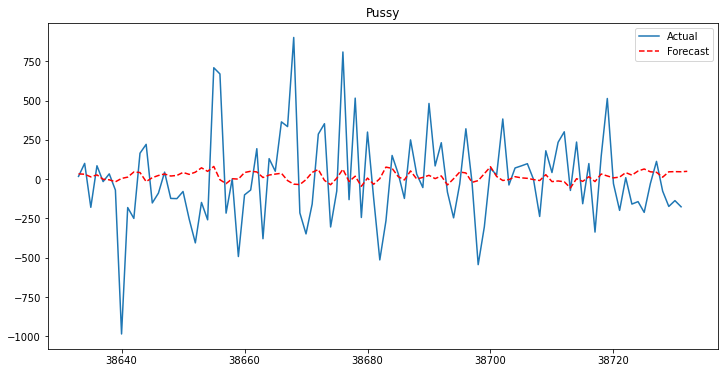

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(test[-100:], label='Actual')
plt.plot(pred[-100:], color='red', linestyle='--', label = 'Forecast')
plt.legend()
plt.title('Pussy')
plt.show()

In [45]:
pred

32937     15.458017
32938    -19.884723
32939     52.633149
32940    -91.626930
32941   -127.283747
            ...    
38728     20.446724
38729     80.442230
38730     53.678799
38731     65.964337
38732    103.892913
Name: open, Length: 5796, dtype: float64

In [25]:
pred = model.predict(X_test)
roc_auc_score(y_test, pred)

0.6398741936886055

In [26]:
for x in range(40, 60, 1):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

40
0.5472739820565907
41
0.555728088336784
42
0.5650448585231194
43
0.5719461697722568
44
0.5778122843340234
45
0.584023464458247
46
0.5881642512077294
47
0.586783988957902
48
0.5917874396135265
49
0.5976535541752933
50
0.6024844720496895
51
0.6028295376121463
52
0.6026570048309179
53
0.6017943409247757
54
0.6005866114561766
55
0.5974810213940649
56
0.5921325051759835
57
0.5854037267080745
58
0.5848861283643892
59
0.5800552104899931


(array([  2.,   6.,   8.,  16.,  25.,  34.,  72.,  91., 148., 235., 305.,
        359., 445., 460., 537., 538., 529., 448., 417., 365., 263., 199.,
        127.,  88.,  38.,  15.,  16.,   6.,   3.,   1.]),
 array([0.12550716, 0.15107446, 0.17664176, 0.20220906, 0.22777636,
        0.25334365, 0.27891095, 0.30447825, 0.33004555, 0.35561285,
        0.38118014, 0.40674744, 0.43231474, 0.45788204, 0.48344933,
        0.50901663, 0.53458393, 0.56015123, 0.58571853, 0.61128582,
        0.63685312, 0.66242042, 0.68798772, 0.71355502, 0.73912231,
        0.76468961, 0.79025691, 0.81582421, 0.84139151, 0.8669588 ,
        0.8925261 ]),
 <BarContainer object of 30 artists>)

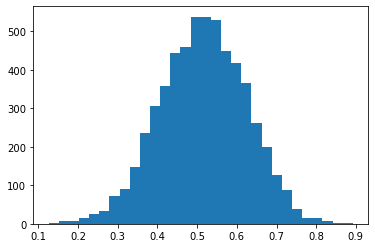

In [27]:
plt.hist(pred, bins=30)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15772\1513186643.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f = np.ravel(x).astype(np.float)


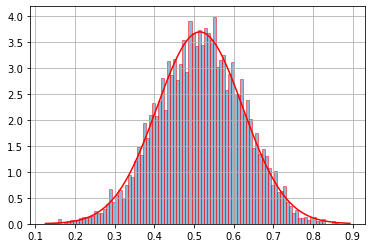

In [28]:
from sklearn import mixture
import scipy.stats as stats

x = pred

f = np.ravel(x).astype(np.float)
f=f.reshape(-1,1)
g = mixture.GaussianMixture(n_components=1, covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_
plt.hist(f, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
# plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='green')
# plt.plot(f_axis,weights[2]*stats.norm.pdf(f_axis,means[2],np.sqrt(covars[2])).ravel(), c='blue')

plt.rcParams['agg.path.chunksize'] = 10000

plt.grid()
plt.show()

In [29]:
y_pred = (pred >= 0.51) * 1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.58      0.60      2935
         1.0       0.59      0.63      0.61      2861

    accuracy                           0.60      5796
   macro avg       0.60      0.60      0.60      5796
weighted avg       0.60      0.60      0.60      5796



In [129]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.head(60)

,feature_name,importance_gain,importance_split
0,exchange_inflow,0.699343,198
1,miner_reserve_USD,0.509660,143
2,exchange_reserve,0.273535,100
3,close_SMMA72,0.155795,20
4,exchange_whale_ratio,0.154495,19
5,low_SMMA96,0.137366,24
6,open_SMMA72,0.099293,20
7,close_SMMA96,0.099250,10
8,low_TEMA4,0.096600,26
9,low_DPO20,0.089024,13


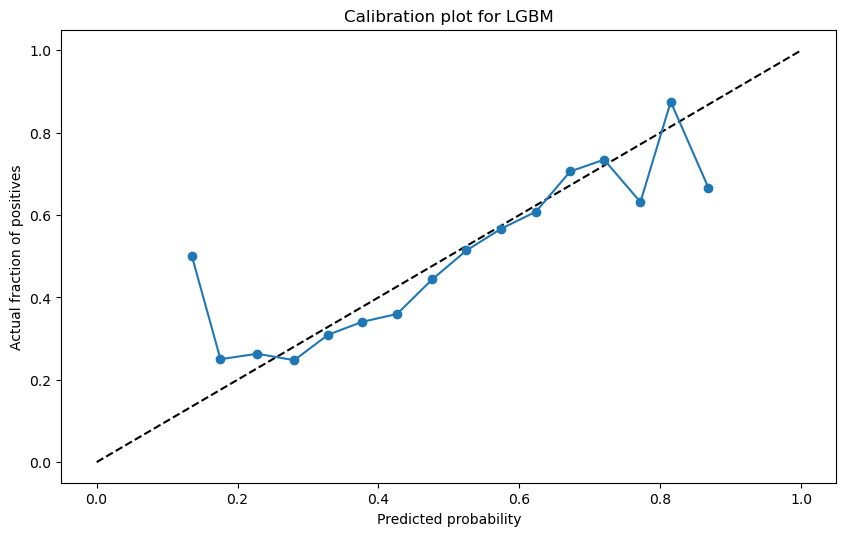

In [32]:
# creating a dataframe of target and probabilities
preds = model.predict(X_test)
prob_df_lgbm = pd.DataFrame({'y':y_test, 'y_hat': preds})

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_lgbm.loc[:,'prob_bin'] = np.digitize(prob_df_lgbm['y_hat'], bins)
prob_df_lgbm.loc[:,'prob_bin_val'] = prob_df_lgbm['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(10,6), dpi=100)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for lgbm
calibration_y = prob_df_lgbm.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_lgbm.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='lgbm')

# legend and titles
plt.title('Calibration plot for LGBM')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.show()

In [33]:
auc_diff = []
corr_feat = []
for f in feat:
    auc = roc_auc_score(df['label'], df[f])
    auc_diff.append(abs(auc - 0.5))
    corr = (df['close'] - df['close'].shift(1)).shift(1).fillna(0).corr(df[f])
    corr_feat.append(corr)

In [34]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'auc_diff': auc_diff,
        'corr_feat': corr_feat,
    })
    .sort_values(['auc_diff', 'corr_feat'], ascending=False)
    .reset_index(drop=True)
)

In [35]:
importance_df.head(50)

,feature_name,auc_diff,corr_feat
0,close_ALMA4,0.062826,-0.475572
1,close_WMA4,0.062200,-0.378487
2,close_EMA4,0.061102,-0.364907
3,close_DEMA4,0.060330,-0.251792
4,close_DEMA8,0.059245,-0.365959
5,close_SMA4,0.059121,-0.419335
6,close_ALMA8,0.057771,-0.446692
7,close_TEMA8,0.057769,-0.309054
8,BOP,0.057333,-0.032368
9,close_WMA8,0.057015,-0.398143


close_WMA4, close_EMA4, close_ALMA4, close_SMA4, close_DEMA8

In [24]:
df['label'] = data_normalization((df['close'] - df['close'].shift(1)).shift(-1), days_range=24)
df.dropna(inplace=True)

In [25]:
X, y = df[feat].iloc[:], df['label'][:]
X_train, X_valid, X_test = X[:int(X.shape[0]*0.7)], X[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], X[int(X.shape[0]*0.85):]
y_train, y_valid, y_test = y[:int(X.shape[0]*0.7)], y[int(X.shape[0]*0.7):int(X.shape[0]*0.85)], y[int(X.shape[0]*0.85):]

In [51]:
linear_r = Lasso(alpha=0.1)

In [52]:
linear_r.fit(X_train, y_train)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+04, tolerance: 5.354e+00
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [53]:
def take_the_error(model_regression, training_set, valid_set, test_set):
    X_train, y_train = training_set[0], training_set[1]
    X_valid, y_valid = valid_set[0], valid_set[1]
    X_test, y_test = test_set[0], test_set[1]
    train_pred = model_regression.predict(X_train)
    valid_pred = model_regression.predict(X_valid)
    test_pred = model_regression.predict(X_test)
    train = (((train_pred * y_train) >= 0) * 1).sum()/len(y_train)
    valid = (((valid_pred * y_valid) >= 0) * 1).sum()/len(y_valid)
    test = (((test_pred * y_test) >= 0) * 1).sum()/len(y_test)
    mse_train, mse_valid, mse_test = mean_squared_error(y_train, train_pred), mean_squared_error(y_valid, valid_pred), mean_squared_error(y_test, test_pred)
    rmse_train, rmse_valid, rmse_test = math.sqrt(mse_train), math.sqrt(mse_valid), math.sqrt(mse_test)
    mape_train, mape_valid, mape_test = mean_absolute_percentage_error(y_train, train_pred), mean_absolute_percentage_error(y_valid, valid_pred), mean_absolute_percentage_error(y_test, test_pred)
    print(f'Train error is: MSE= {mse_train}, RMSE={rmse_train}, MAPE={mape_train}, ACC={train}')
    print(f'Valid error is: MSE= {mse_valid}, RMSE={rmse_valid}, MAPE={mape_valid}, ACC={valid}')
    print(f'Test error is: MSE= {mse_test}, RMSE={rmse_test}, MAPE={mape_test}, ACC={test}')
    return train_pred, valid_pred, test_pred

In [54]:
y_train_pred_r, y_valid_pred_r, y_test_pred_r = take_the_error(linear_r, [X_train, y_train], [X_valid, y_valid], [X_test, y_test])

Train error is: MSE= 1.9078463849841782, RMSE=1.3812481257848563, MAPE=159333943830.228, ACC=0.64002828854314
Valid error is: MSE= 1.224716793591407, RMSE=1.1066692340493645, MAPE=3.2721694489665123, ACC=0.6556655665566556
Test error is: MSE= 1.1662650826026237, RMSE=1.0799375364356143, MAPE=63621283194.41871, ACC=0.6556655665566556


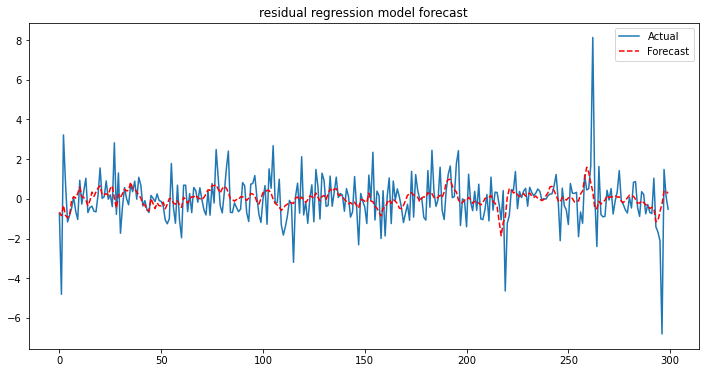

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.tolist()[-1000:-700], label='Actual')
plt.plot(y_test_pred_r.tolist()[-1000:-700], color='red', linestyle='--', label = 'Forecast')
plt.legend()
plt.title('residual regression model forecast')
plt.show()

In [87]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'mape',
    'metric': ['mape','rmse'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='mape',
        early_stopping_rounds=1000)

C:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340445 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	valid_0's mape: 0.998187	valid_0's rmse: 388.443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's mape: 0.998188	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's mape: 0.998192	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's mape: 0.998189	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's mape: 0.99819	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's mape: 0.998194	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's mape: 0.998194	valid_0's rmse: 388.442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's mape: 0.

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        3.0000e+00, 8.0000e+00, 7.0000e+00, 1.2000e+01, 1.9000e+01,
        3.0000e+01, 7.5000e+01, 1.4600e+02, 3.7900e+02, 1.0440e+03,
        4.3910e+03, 2.0931e+04, 7.1570e+03, 1.3950e+03, 4.2100e+02,
        1.5700e+02, 7.1000e+01, 3.8000e+01, 1.7000e+01, 1.0000e+01,
        6.0000e+00, 6.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.20103321, -0.19347928, -0.18592534, -0.1783714 , -0.17081747,
        -0.16326353, -0.1557096 , -0.14815566, -0.14060172, -0.13304779,
        -0.12549385, -0.11793991, -0.11038598, -0.10283204, -0.0952781 ,
        -0.08772417, -0.08017023, -0.0726163 , -0.06506236, -0.05750842,
        -0.04995449, -0.04

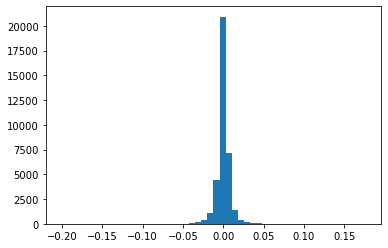

In [34]:
plt.hist(np.log(df['close'] / df['close'].shift(1)), bins=50)

<AxesSubplot:>

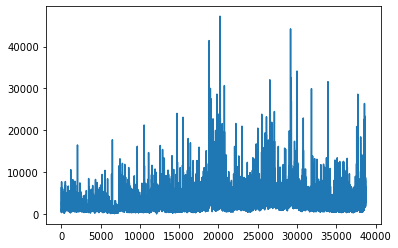

In [37]:
df['volume'].plot()

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', bootstrap=True, 
                                  oob_score=False, n_jobs=-1, random_state=1234, verbose=1)

In [40]:
model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=1234,
                       verbose=1)

In [41]:
pred = model_rf.predict_proba(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [42]:
pred = pred[:, 1] 

In [43]:
roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


1.0

In [45]:
roc_auc_score(y_valid, model_rf.predict_proba(X_valid)[:, 1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5385933249057554

In [46]:
roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5450553197325301

In [47]:
accuracy_score(y_train, (model_rf.predict_proba(X_train)[:, 1] >= 0.5) * 1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


1.0

In [48]:
accuracy_score(y_valid, (model_rf.predict_proba(X_valid)[:, 1] >= 0.5) * 1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5232919254658385

In [50]:
accuracy_score(y_test, (model_rf.predict_proba(X_test)[:, 1] >= 0.5) * 1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5276867345178541

In [293]:
for x in range(40, 60, 1):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

40
0.5019837847162325
41
0.5037088149042608
42
0.5042263239606694
43
0.5066413662239089
44
0.5078488873555287
45
0.5125064688632051
46
0.5154390201828531
47
0.519751595652924
48
0.5202691047093324
49
0.5228566499913748
50
0.5276867345178541
51
0.5323443160255305
52
0.5280317405554598
53
0.5380369156460239
54
0.5401069518716578
55
0.5332068311195446
56
0.5326893220631361
57
0.5325168190443332
58
0.5323443160255305
59
0.5321718130067277


In [295]:
model_rf.get_params([1])

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 1,
 'warm_start': False}

In [296]:
model_rf.feature_importances_

array([0.0013091 , 0.00135769, 0.00147568, 0.00126785, 0.00154281,
       0.00168565, 0.00164514, 0.00154974, 0.00151599, 0.00075802,
       0.        , 0.0007428 , 0.00101112, 0.00087274, 0.00103772,
       0.00157857, 0.00122563, 0.0012996 , 0.00128828, 0.00152989,
       0.00358279, 0.00198618, 0.00073212, 0.0009797 , 0.00175381,
       0.00189504, 0.0010734 , 0.00120462, 0.00153933, 0.00118144,
       0.00123473, 0.00156133, 0.00119515, 0.00097474, 0.00131023,
       0.00146279, 0.00131349, 0.00104354, 0.00119841, 0.00139595,
       0.00159972, 0.00138337, 0.001399  , 0.00128625, 0.00113381,
       0.00087878, 0.00161001, 0.00133633, 0.00159447, 0.00226456,
       0.00252027, 0.00215369, 0.00247409, 0.00145011, 0.00258485,
       0.0013378 , 0.00126451, 0.00127767, 0.00120888, 0.00091857,
       0.00132992, 0.00105145, 0.00160137, 0.00158279, 0.00148216,
       0.00126225, 0.00139389, 0.00134968, 0.0017884 , 0.00157755,
       0.00143677, 0.00128719, 0.00122171, 0.00080268, 0.00110

In [298]:
importance_df = pd.DataFrame()
importance_df['feature'] = model_rf.feature_names_in_
importance_df['importance'] = model_rf.feature_importances_

In [302]:
importance_df.sort_values('importance', ascending=False).head(20)

,feature,importance
20,BOP,0.003583
54,close_HMA4,0.002585
50,close_TEMA4,0.002520
52,close_DEMA4,0.002474
49,close_ALMA4,0.002265
657,log_volume_resid_divide_prev,0.002185
51,close_EMA4,0.002154
685,coinbase_premium_index,0.002108
683,miner_outflow,0.002082
679,exchange_whale_ratio,0.002045


In [308]:
from sklearn import tree
fn = X.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model_rf.estimators_[0],
               feature_names = fn, 
               filled = True);

Error in callback <function flush_figures at 0x00000287C60D79D0> (for post_execute):



KeyboardInterrupt



[Text(0.41082644152613257, 0.9864864864864865, 'X[359] <= -0.003\ngini = 0.499\nsamples = 17057\nvalue = [13078, 13970]'),
 Text(0.13142937324040205, 0.9594594594594594, 'X[428] <= -0.022\ngini = 0.497\nsamples = 5911\nvalue = [5062, 4316]'),
 Text(0.057672421281941624, 0.9324324324324325, 'X[127] <= 0.007\ngini = 0.499\nsamples = 1177\nvalue = [881, 974]'),
 Text(0.03939060328236929, 0.9054054054054054, 'X[169] <= -0.027\ngini = 0.5\nsamples = 1141\nvalue = [874, 928]'),
 Text(0.02081785256067572, 0.8783783783783784, 'X[35] <= -0.01\ngini = 0.498\nsamples = 806\nvalue = [671, 598]'),
 Text(0.00974553619159628, 0.8513513513513513, 'X[557] <= -0.502\ngini = 0.494\nsamples = 253\nvalue = [177, 221]'),
 Text(0.003506896183042874, 0.8243243243243243, 'X[575] <= 0.7\ngini = 0.458\nsamples = 70\nvalue = [69, 38]'),
 Text(0.0017106810648989629, 0.7972972972972973, 'X[709] <= 1.948\ngini = 0.259\nsamples = 37\nvalue = [50, 9]'),
 Text(0.0006842724259595852, 0.7702702702702703, 'X[25] <= 11.655

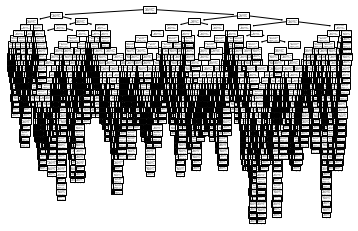

In [310]:
tree.plot_tree(model_rf.estimators_[0])

## Linear method

In [23]:
logistic_regression = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1, fit_intercept=True, 
                                         max_iter=1000, multi_class='auto', verbose=1, warm_start=False, n_jobs=-1, 
                                         l1_ratio=None)

In [24]:
logistic_regression.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished


LogisticRegression(C=1, max_iter=1000, n_jobs=-1, verbose=1)

In [25]:
pred = logistic_regression.predict_proba(X_test)[:, 1]

In [28]:
roc_auc_score(y_train, logistic_regression.predict_proba(X_train)[:, 1])

0.5238756284537502

In [35]:
roc_auc_score(y_valid, logistic_regression.predict_proba(X_valid)[:, 1])

0.5160245253235219

In [26]:
roc_auc_score(y_test, pred)

0.5203167991603705

In [32]:
accuracy_score(y_train, (logistic_regression.predict_proba(X_train)[:, 1] >= 0.5) * 1)

0.5255102040816326

In [33]:
accuracy_score(y_valid, (logistic_regression.predict_proba(X_valid)[:, 1] >= 0.5) * 1)

0.5044858523119393

In [34]:
accuracy_score(y_test, (logistic_regression.predict_proba(X_test)[:, 1] >= 0.5) * 1)

0.5012937726410213

In [315]:
for x in range(40, 60, 1):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

40
0.49335863377609107
41
0.49318613075728823
42
0.49335863377609107
43
0.49318613075728823
44
0.49266862170087977
45
0.49266862170087977
46
0.4923236156632741
47
0.4919786096256685
48
0.4947386579265137
49
0.49560117302052786
50
0.5012937726410213
51
0.516646541314473
52
0.5104364326375711
53
0.5123339658444023
54
0.5119889598067966
55
0.510608935656374
56
0.5088839054683457
57
0.509573917543557
58
0.5088839054683457
59
0.5078488873555287


In [36]:
from sklearn.svm import SVC

In [42]:
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True, 
          tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', 
          break_ties=False, random_state=None)

In [43]:
svc.fit(X_train, y_train)

SVC(probability=True)

In [44]:
pred = svc.predict_proba(X_test)

In [45]:
pred = pred[:, 1]

In [52]:
roc_auc_score(y_train, svc.predict_proba(X_train)[:, 1])

0.5297384390085098

In [53]:
roc_auc_score(y_valid, svc.predict_proba(X_valid)[:, 1])

0.5030373221023849

In [57]:
roc_auc_score(y_test, pred)

0.5083829609318973

In [54]:
accuracy_score(y_train, (svc.predict_proba(X_train)[:, 1] >= 0.5) * 1)

0.5139751552795031

In [55]:
accuracy_score(y_valid, (svc.predict_proba(X_valid)[:, 1] >= 0.5) * 1)

0.506383712905452

In [56]:
accuracy_score(y_test, (svc.predict_proba(X_test)[:, 1] >= 0.5) * 1)

0.4935311367948939

In [58]:
for x in range(40, 60, 1):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

40
0.4935311367948939
41
0.4935311367948939
42
0.4935311367948939
43
0.4935311367948939
44
0.4935311367948939
45
0.4935311367948939
46
0.4935311367948939
47
0.4935311367948939
48
0.4935311367948939
49
0.4935311367948939
50
0.4935311367948939
51
0.4952561669829222
52
0.5064688632051061
53
0.5064688632051061
54
0.5064688632051061
55
0.5064688632051061
56
0.5064688632051061
57
0.5064688632051061
58
0.5064688632051061
59
0.5064688632051061


In [322]:
accuracy_score(y_test, pred)

0.4947386579265137

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [23]:
lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, 
                                 store_covariance=False, tol=0.0001, covariance_estimator=None)

In [24]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [25]:
pred = lda.predict_proba(X_test)[:, 1]

In [26]:
roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])

0.635068143322179

In [27]:
roc_auc_score(y_valid, lda.predict_proba(X_valid)[:, 1])

0.5444901682558189

In [32]:
roc_auc_score(y_test, pred)

0.5443778113443309

In [35]:
accuracy_score(y_train, (lda.predict_proba(X_train)[:, 1] >= 0.5) * 1)

0.597086660751257

In [37]:
accuracy_score(y_valid, (lda.predict_proba(X_valid)[:, 1] >= 0.5) * 1)

0.529848171152519

In [31]:
accuracy_score(y_test, (lda.predict_proba(X_test)[:, 1] >= 0.5) * 1)

0.5326893220631361

In [35]:
for x in range(40, 60, 1):
    print(x)
    y_pred = (pred >= x/100) * 1
    print(accuracy_score(y_test, y_pred))

40
0.5330343281007418
41
0.5349318613075729
42
0.5340693462135587
43
0.5356218733827842
44
0.531826806969122
45
0.5325168190443332
46
0.531826806969122
47
0.5349318613075729
48
0.5314818009315163
49
0.5319993099879248
50
0.5326893220631361
51
0.5306192858375022
52
0.5302742797998965
53
0.5304467828186993
54
0.529756770743488
55
0.5299292737622908
56
0.5269967224426427
57
0.5244091771606003
58
0.519751595652924
59
0.5185440745213041
